In [3]:
import LatinHypercubeSampling

function sample_parameters_from_LHC(number_of_sets, number_of_parameters, gens)
    plan, _ = LatinHypercubeSampling.LHCoptim(number_of_sets, number_of_parameters, gens)
    params = LatinHypercubeSampling.scaleLHC(plan, [(0, 1) for _ in 1:number_of_parameters])
    return [params[i,:] for i in 1:number_of_sets]
end

sample_parameters_from_LHC (generic function with 1 method)

In [4]:
include("CRNevo.jl")
include("CRNExplore.jl")
include("SymbolicOps.jl")
eval(Meta.parse("@variables " * join([ifelse(i==3 && j==80, "", "ks_" * string(i) * "_" * string(j) *"(t), ") for i in 1:3 for j in 1:80]) * "ks_" * string(3) * "_" * string(80) * "(t)"))
include("CRNevo.jl")
include("CRNExplore.jl")
include("SymbolicOps.jl")


# --- GA parameters
genetic_pool_size = 1000
elite = 100
worst = 200
death_rate = 0.05
mutation_rate = 0.30
gradient_mutation_rate = 0.01
duplication_rate = 0.20
crossover_rate = 0.
max_generations = 100
p_cross = 0.1

# --- GD parameters

# fixed, basic steps

N = 3
np = count_parameters(N)
target = N
crn = create_reactions(N)
ode_crn = convert(ODESystem, crn)
pars_l = assemble_opt_parameters_and_varables([0 for _ in 1:np], N) # just for the names
ext_ode = make_sensitivity_ode(ode_crn, pars_l.p)
t0 = 10.0
t1 = 20.0

# set up gd problem 

crn_info = (
    crn = crn, 
    ode_crn = ode_crn,
    ext_ode = ext_ode,
    np = np,
    N = N,
    target = target
)

# set up the loss function

gd_loss_options = (
    weights = [1., 10., 1.0/100, 1.], #[2.0, 1.0/3, 1.0/80, 100.0], #[1., 0.01, 0.01, 1.] # this descends smoothly
    p=1.0,
    d=0.5,
    f_ss=0.5,
    norm_for_sensitivity_loss = 1, 
    norm_for_ss_loss = 1,
    norm_for_adaptation_loss = 1,
    n_losses = 4
)

loss_blueprint = prepare_args(nothing, target, t0, t1, pars_l, gd_loss_options.weights, gd_loss_options.p, gd_loss_options.d, gd_loss_options.f_ss, gd_loss_options.norm_for_sensitivity_loss, gd_loss_options.norm_for_ss_loss, gd_loss_options.norm_for_adaptation_loss)

gd_options = (
    alpha = 0.1,
    n_iter = 10,
    use_pruning_heuristic = false,
    clip_value = nothing,
    use_gradient_normalization = true,
    use_adagrad = true, # overrides use_adam!
    use_adam = false,
    use_random_perturbation = false,
    verbose = false,
    # placed here for convenience, should be in gd_loss_options
    symbolic_derivatives_of_loss = compute_symbolic_derivatives_of_loss(total_loss_symbolic(loss_blueprint))
)

gd_perturbation_options = (
    t0 = t0,
    t1 = t1,
    input = 1.,
    perturbation = 1.,
    K = 5,
    perturbation_list = [1.5, 1.75, 2.25, 2.5] .-1,
    loss_blueprint = loss_blueprint
)


#s_loss = stochastic_loss(K, prob, perturb!, tspan, target, tspan[2]/2., tspan[2], sensitivity_dt, sensitivity_offset, steady_d, l1, l2, l3, l4, absolute, rtol, atol, maxiters)
#mutate_with_GD = (p) -> gradient_descent(ALPHA, NITER, p, s_loss, true, false, 0.01/ALPHA, use_adagrad).minimizer
mutate_with_GD = (p) -> symbolic_gradient_descent(p, crn_info, gd_options, gd_perturbation_options, gd_loss_options).parameters
function make_ev_loss(crn_info, gd_options, gd_perturbation_options, gd_loss_options)
    function ev_loss(p)
        pars_l = assemble_opt_parameters_and_varables(p, crn_info.N)
        solutions = run_with_fixed_perturbations(crn_info.crn, p, pars_l, gd_perturbation_options.input,  gd_perturbation_options.perturbation_list, gd_perturbation_options.t0, gd_perturbation_options.t1)
        losses = zeros(length(solutions))
        Threads.@threads for i in 1:length(solutions)
            loss_args = update_args(solutions[i], crn_info.target, gd_perturbation_options.t0, gd_perturbation_options.t1, pars_l, gd_perturbation_options.loss_blueprint, gd_loss_options.p, gd_loss_options.d, gd_loss_options.f_ss) 
            losses[i] = total_loss_eval(loss_args).total.val
        end
        return sum(losses)/length(gd_perturbation_options.perturbation_list)
    end
    return ev_loss
end
loss_function = make_ev_loss(crn_info, gd_options, gd_perturbation_options, gd_loss_options)
print("setup done!")


setup done!

In [5]:
# for i in 1:100
#     loss_function([1 for _ in 1:np])
# end

In [6]:
println("Testing symbolic gradient descent")
println(loss_function([1 for _ in 1:np]))
test_p = symbolic_gradient_descent([1 for _ in 1:np], crn_info, gd_options, gd_perturbation_options, gd_loss_options)
println(loss_function(test_p.parameters))

Testing symbolic gradient descent


0.8753718814820859


0.4986927098440508


initialize the GA problem 

In [7]:
parameter_pool = sample_parameters_from_LHC(genetic_pool_size, np, 10) #[[rand() for _ in 1:np] for _ in 1:genetic_pool_size]
is_updated = [false for _ in 1:genetic_pool_size]
fitness = [0. for _ in 1:genetic_pool_size]

dp = 0.05

state = (pool = parameter_pool, is_updated = is_updated, fitness = fitness, history = (best_loss = [], mean_loss = []))
print("done")

done

In [8]:
using ProgressBars
max_generations = 1000
for i in ProgressBar(1:max_generations)
    state = symbolic_evolve(crn, loss_function, state, dp, genetic_pool_size, elite, worst, death_rate, mutation_rate, gradient_mutation_rate, mutate_with_GD, duplication_rate, crossover_rate, p_cross)
end

0.0%┣                                            ┫ 0/1.0k [00:03<-49:-1, -3s/it]


0.1%┣                                         ┫ 1/1.0k [00:25<Inf:Inf, InfGs/it]


0.2%┣                                          ┫ 2/1.0k [00:44<12:05:29, 44s/it]


0.3%┣▏                                         ┫ 3/1.0k [00:51<07:06:26, 26s/it]


0.4%┣▏                                         ┫ 4/1.0k [00:59<05:28:52, 20s/it]


0.5%┣▏                                         ┫ 5/1.0k [01:07<04:37:39, 17s/it]


0.6%┣▎                                         ┫ 6/1.0k [01:15<04:08:25, 15s/it]


0.7%┣▎                                         ┫ 7/1.0k [01:22<03:47:12, 14s/it]


0.8%┣▍                                         ┫ 8/1.0k [01:39<03:54:19, 14s/it]


0.9%┣▍                                         ┫ 9/1.0k [01:55<03:57:51, 14s/it]


1.0%┣▍                                        ┫ 10/1.0k [02:02<03:43:48, 14s/it]


1.1%┣▌                                        ┫ 11/1.0k [02:17<03:45:26, 14s/it]


1.2%┣▌                                        ┫ 12/1.0k [02:24<03:34:53, 13s/it]


1.3%┣▌                                        ┫ 13/1.0k [02:31<03:26:38, 13s/it]


1.4%┣▋                                        ┫ 14/1.0k [02:38<03:19:34, 12s/it]


1.5%┣▋                                        ┫ 15/1.0k [02:45<03:13:22, 12s/it]


1.6%┣▋                                        ┫ 16/1.0k [03:00<03:16:38, 12s/it]


1.7%┣▊                                        ┫ 17/1.0k [03:14<03:19:08, 12s/it]


1.8%┣▊                                        ┫ 18/1.0k [03:32<03:23:47, 12s/it]


1.9%┣▉                                        ┫ 19/1.0k [03:46<03:25:34, 13s/it]


2.0%┣▉                                        ┫ 20/1.0k [04:02<03:27:58, 13s/it]


2.1%┣▉                                        ┫ 21/1.0k [04:17<03:29:18, 13s/it]


2.2%┣█                                        ┫ 22/1.0k [04:23<03:24:14, 13s/it]


2.3%┣█                                        ┫ 23/1.0k [04:38<03:25:55, 13s/it]


2.4%┣█                                        ┫ 24/1.0k [04:45<03:21:37, 12s/it]


2.5%┣█                                        ┫ 25/1.0k [05:00<03:23:25, 13s/it]


2.6%┣█                                        ┫ 26/1.0k [05:15<03:24:31, 13s/it]


2.7%┣█                                        ┫ 27/1.0k [05:30<03:25:49, 13s/it]


2.8%┣█▏                                       ┫ 28/1.0k [05:44<03:26:34, 13s/it]


2.9%┣█▏                                       ┫ 29/1.0k [05:51<03:23:04, 13s/it]


3.0%┣█▎                                       ┫ 30/1.0k [05:58<03:19:46, 12s/it]


3.1%┣█▎                                       ┫ 31/1.0k [06:14<03:21:07, 12s/it]


3.2%┣█▎                                       ┫ 32/1.0k [06:29<03:22:18, 13s/it]


3.3%┣█▍                                       ┫ 33/1.0k [06:44<03:23:16, 13s/it]


3.4%┣█▍                                       ┫ 34/1.0k [07:00<03:24:40, 13s/it]


3.5%┣█▍                                       ┫ 35/1.0k [07:16<03:26:23, 13s/it]


3.6%┣█▌                                       ┫ 36/1.0k [07:32<03:27:21, 13s/it]


3.7%┣█▌                                       ┫ 37/1.0k [07:46<03:27:42, 13s/it]


3.8%┣█▋                                       ┫ 38/1.0k [07:52<03:24:45, 13s/it]


3.9%┣█▋                                       ┫ 39/1.0k [07:59<03:22:05, 13s/it]


4.0%┣█▋                                       ┫ 40/1.0k [08:07<03:19:43, 12s/it]


4.1%┣█▊                                       ┫ 41/1.0k [08:21<03:20:13, 13s/it]


4.2%┣█▊                                       ┫ 42/1.0k [08:28<03:17:51, 12s/it]


4.3%┣█▊                                       ┫ 43/1.0k [08:35<03:15:41, 12s/it]


4.4%┣█▉                                       ┫ 44/1.0k [08:50<03:16:33, 12s/it]


4.5%┣█▉                                       ┫ 45/1.0k [08:58<03:14:27, 12s/it]


4.6%┣█▉                                       ┫ 46/1.0k [09:13<03:15:15, 12s/it]


4.7%┣██                                       ┫ 47/1.0k [09:28<03:16:00, 12s/it]


4.8%┣██                                       ┫ 48/1.0k [09:42<03:16:38, 12s/it]


4.9%┣██                                       ┫ 49/1.0k [09:50<03:14:48, 12s/it]


5.0%┣██                                       ┫ 50/1.0k [09:57<03:12:47, 12s/it]


5.1%┣██                                       ┫ 51/1.0k [10:11<03:13:20, 12s/it]


5.2%┣██▏                                      ┫ 52/1.0k [10:25<03:13:42, 12s/it]


5.3%┣██▏                                      ┫ 53/1.0k [10:35<03:12:46, 12s/it]


5.4%┣██▏                                      ┫ 54/1.0k [10:43<03:11:19, 12s/it]


5.5%┣██▎                                      ┫ 55/1.0k [10:58<03:12:01, 12s/it]


5.6%┣██▎                                      ┫ 56/1.0k [11:29<03:17:06, 13s/it]


5.7%┣██▍                                      ┫ 57/1.0k [11:44<03:17:36, 13s/it]


5.8%┣██▍                                      ┫ 58/1.0k [11:51<03:15:47, 12s/it]


5.9%┣██▍                                      ┫ 59/1.0k [11:58<03:14:02, 12s/it]


6.0%┣██▌                                      ┫ 60/1.0k [12:12<03:14:28, 12s/it]


6.1%┣██▌                                      ┫ 61/1.0k [12:27<03:14:54, 12s/it]


6.2%┣██▌                                      ┫ 62/1.0k [12:46<03:16:13, 13s/it]


6.3%┣██▋                                      ┫ 63/1.0k [12:53<03:14:44, 12s/it]


6.4%┣██▋                                      ┫ 64/1.0k [13:09<03:15:20, 13s/it]


6.5%┣██▋                                      ┫ 65/1.0k [13:24<03:15:40, 13s/it]


6.6%┣██▊                                      ┫ 66/1.0k [13:38<03:15:53, 13s/it]


6.7%┣██▊                                      ┫ 67/1.0k [13:52<03:15:57, 13s/it]


6.8%┣██▉                                      ┫ 68/1.0k [14:06<03:16:13, 13s/it]


6.9%┣██▉                                      ┫ 69/1.0k [14:22<03:16:39, 13s/it]


7.0%┣██▉                                      ┫ 70/1.0k [14:38<03:17:13, 13s/it]


7.1%┣███                                      ┫ 71/1.0k [14:45<03:15:48, 13s/it]


7.2%┣███                                      ┫ 72/1.0k [15:00<03:16:03, 13s/it]


7.3%┣███                                      ┫ 73/1.0k [15:15<03:16:23, 13s/it]


7.4%┣███                                      ┫ 74/1.0k [15:22<03:14:58, 13s/it]


7.5%┣███                                      ┫ 75/1.0k [15:29<03:13:33, 13s/it]


7.6%┣███▏                                     ┫ 76/1.0k [15:44<03:13:45, 13s/it]


7.7%┣███▏                                     ┫ 77/1.0k [15:51<03:12:31, 13s/it]


7.8%┣███▏                                     ┫ 78/1.0k [16:23<03:16:13, 13s/it]


7.9%┣███▎                                     ┫ 79/1.0k [16:38<03:16:20, 13s/it]


8.0%┣███▎                                     ┫ 80/1.0k [16:53<03:16:41, 13s/it]


8.1%┣███▎                                     ┫ 81/1.0k [17:08<03:16:54, 13s/it]


8.2%┣███▍                                     ┫ 82/1.0k [17:31<03:18:34, 13s/it]


8.3%┣███▍                                     ┫ 83/1.0k [17:45<03:18:34, 13s/it]


8.4%┣███▍                                     ┫ 84/1.0k [18:00<03:18:40, 13s/it]


8.5%┣███▌                                     ┫ 85/1.0k [18:07<03:17:18, 13s/it]


8.6%┣███▌                                     ┫ 86/1.0k [18:13<03:15:53, 13s/it]


8.7%┣███▋                                     ┫ 87/1.0k [18:20<03:14:38, 13s/it]


8.8%┣███▋                                     ┫ 88/1.0k [18:27<03:13:20, 13s/it]


8.9%┣███▋                                     ┫ 89/1.0k [18:34<03:12:10, 13s/it]


9.0%┣███▊                                     ┫ 90/1.0k [18:49<03:12:25, 13s/it]


9.1%┣███▊                                     ┫ 91/1.0k [19:03<03:12:29, 13s/it]


9.2%┣███▊                                     ┫ 92/1.0k [19:10<03:11:16, 13s/it]


9.3%┣███▉                                     ┫ 93/1.0k [19:32<03:12:35, 13s/it]


9.4%┣███▉                                     ┫ 94/1.0k [19:46<03:12:36, 13s/it]


9.5%┣████                                     ┫ 95/1.0k [20:01<03:12:40, 13s/it]


9.6%┣████                                     ┫ 96/1.0k [20:08<03:11:33, 13s/it]


9.7%┣████                                     ┫ 97/1.0k [20:22<03:11:34, 13s/it]


9.8%┣████                                     ┫ 98/1.0k [20:28<03:10:23, 13s/it]


9.9%┣████                                     ┫ 99/1.0k [20:43<03:10:33, 13s/it]


10.0%┣████                                   ┫ 100/1.0k [20:50<03:09:26, 13s/it]


10.1%┣████                                   ┫ 101/1.0k [21:04<03:09:28, 13s/it]


10.2%┣████                                   ┫ 102/1.0k [21:19<03:09:35, 13s/it]


10.3%┣████                                   ┫ 103/1.0k [21:36<03:10:02, 13s/it]


10.4%┣████                                   ┫ 104/1.0k [21:43<03:08:57, 13s/it]


10.5%┣████                                   ┫ 105/1.0k [21:51<03:07:58, 13s/it]


10.6%┣████▏                                  ┫ 106/1.0k [22:05<03:08:02, 13s/it]


10.7%┣████▏                                  ┫ 107/1.0k [22:21<03:08:16, 13s/it]


10.8%┣████▏                                  ┫ 108/1.0k [22:35<03:08:16, 13s/it]


10.9%┣████▎                                  ┫ 109/1.0k [22:50<03:08:26, 13s/it]


11.0%┣████▎                                  ┫ 110/1.0k [23:05<03:08:30, 13s/it]


11.1%┣████▎                                  ┫ 111/1.0k [23:21<03:08:41, 13s/it]


11.2%┣████▍                                  ┫ 112/1.0k [23:28<03:07:40, 13s/it]


11.3%┣████▍                                  ┫ 113/1.0k [23:34<03:06:42, 13s/it]


11.4%┣████▌                                  ┫ 114/1.0k [23:41<03:05:44, 13s/it]


11.5%┣████▌                                  ┫ 115/1.0k [23:56<03:05:47, 13s/it]


11.6%┣████▌                                  ┫ 116/1.0k [24:12<03:06:01, 13s/it]


11.7%┣████▋                                  ┫ 117/1.0k [24:26<03:06:01, 13s/it]


11.8%┣████▋                                  ┫ 118/1.0k [24:33<03:05:05, 13s/it]


11.9%┣████▋                                  ┫ 119/1.0k [24:40<03:04:07, 13s/it]


12.0%┣████▊                                  ┫ 120/1.0k [24:54<03:04:08, 13s/it]


12.1%┣████▊                                  ┫ 121/1.0k [25:10<03:04:18, 13s/it]


12.2%┣████▊                                  ┫ 122/1.0k [25:17<03:03:26, 13s/it]


12.3%┣████▉                                  ┫ 123/1.0k [25:31<03:03:27, 13s/it]


12.4%┣████▉                                  ┫ 124/1.0k [25:38<03:02:35, 13s/it]


12.5%┣████▉                                  ┫ 125/1.0k [25:53<03:02:37, 13s/it]


12.6%┣█████                                  ┫ 126/1.0k [26:08<03:02:43, 13s/it]


12.7%┣█████                                  ┫ 127/1.0k [26:24<03:02:55, 13s/it]


12.8%┣█████                                  ┫ 128/1.0k [26:31<03:02:01, 13s/it]


12.9%┣█████                                  ┫ 129/1.0k [26:45<03:02:02, 13s/it]


13.0%┣█████                                  ┫ 130/1.0k [27:09<03:03:05, 13s/it]


13.1%┣█████                                  ┫ 131/1.0k [27:24<03:03:06, 13s/it]


13.2%┣█████▏                                 ┫ 132/1.0k [27:30<03:02:15, 13s/it]


13.3%┣█████▏                                 ┫ 133/1.0k [27:37<03:01:24, 13s/it]


13.4%┣█████▎                                 ┫ 134/1.0k [27:52<03:01:26, 13s/it]


13.5%┣█████▎                                 ┫ 135/1.0k [28:07<03:01:28, 13s/it]


13.6%┣█████▎                                 ┫ 136/1.0k [28:30<03:02:22, 13s/it]


13.7%┣█████▍                                 ┫ 137/1.0k [28:52<03:03:07, 13s/it]


13.8%┣█████▍                                 ┫ 138/1.0k [29:06<03:03:07, 13s/it]


13.9%┣█████▍                                 ┫ 139/1.0k [29:20<03:03:03, 13s/it]


14.0%┣█████▌                                 ┫ 140/1.0k [29:27<03:02:13, 13s/it]


14.1%┣█████▌                                 ┫ 141/1.0k [29:42<03:02:16, 13s/it]


14.2%┣█████▌                                 ┫ 142/1.0k [30:00<03:02:33, 13s/it]


14.3%┣█████▋                                 ┫ 143/1.0k [30:07<03:01:45, 13s/it]


14.4%┣█████▋                                 ┫ 144/1.0k [30:22<03:01:46, 13s/it]


14.5%┣█████▋                                 ┫ 145/1.0k [30:28<03:00:56, 13s/it]


14.6%┣█████▊                                 ┫ 146/1.0k [30:43<03:00:55, 13s/it]


14.7%┣█████▊                                 ┫ 147/1.0k [31:07<03:01:48, 13s/it]


14.8%┣█████▊                                 ┫ 148/1.0k [31:22<03:01:49, 13s/it]


14.9%┣█████▉                                 ┫ 149/1.0k [31:37<03:01:48, 13s/it]


15.0%┣█████▉                                 ┫ 150/1.0k [31:44<03:01:00, 13s/it]


15.1%┣██████                                 ┫ 151/1.0k [31:59<03:01:04, 13s/it]


15.2%┣██████                                 ┫ 152/1.0k [32:07<03:00:19, 13s/it]


15.3%┣██████                                 ┫ 153/1.0k [32:22<03:00:19, 13s/it]


15.4%┣██████                                 ┫ 154/1.0k [32:36<03:00:16, 13s/it]


15.5%┣██████                                 ┫ 155/1.0k [32:43<02:59:29, 13s/it]


15.6%┣██████                                 ┫ 156/1.0k [32:57<02:59:25, 13s/it]


15.7%┣██████▏                                ┫ 157/1.0k [33:12<02:59:26, 13s/it]


15.8%┣██████▏                                ┫ 158/1.0k [33:29<02:59:32, 13s/it]


15.9%┣██████▏                                ┫ 159/1.0k [33:35<02:58:46, 13s/it]


16.0%┣██████▎                                ┫ 160/1.0k [33:50<02:58:43, 13s/it]


16.1%┣██████▎                                ┫ 161/1.0k [34:05<02:58:45, 13s/it]


16.2%┣██████▎                                ┫ 162/1.0k [34:21<02:58:47, 13s/it]


16.3%┣██████▍                                ┫ 163/1.0k [34:28<02:58:07, 13s/it]


16.4%┣██████▍                                ┫ 164/1.0k [34:35<02:57:22, 13s/it]


16.5%┣██████▍                                ┫ 165/1.0k [34:42<02:56:41, 13s/it]


16.6%┣██████▌                                ┫ 166/1.0k [34:57<02:56:37, 13s/it]


16.7%┣██████▌                                ┫ 167/1.0k [35:11<02:56:35, 13s/it]


16.8%┣██████▌                                ┫ 168/1.0k [35:26<02:56:31, 13s/it]


16.9%┣██████▋                                ┫ 169/1.0k [35:40<02:56:26, 13s/it]


17.0%┣██████▋                                ┫ 170/1.0k [35:56<02:56:30, 13s/it]


17.1%┣██████▊                                ┫ 171/1.0k [36:12<02:56:31, 13s/it]


17.2%┣██████▊                                ┫ 172/1.0k [36:26<02:56:27, 13s/it]


17.3%┣██████▊                                ┫ 173/1.0k [36:33<02:55:45, 13s/it]


17.4%┣██████▉                                ┫ 174/1.0k [36:49<02:55:45, 13s/it]


17.5%┣██████▉                                ┫ 175/1.0k [37:04<02:55:43, 13s/it]


17.6%┣██████▉                                ┫ 176/1.0k [37:19<02:55:41, 13s/it]


17.7%┣███████                                ┫ 177/1.0k [37:34<02:55:42, 13s/it]


17.8%┣███████                                ┫ 178/1.0k [37:49<02:55:39, 13s/it]


17.9%┣███████                                ┫ 179/1.0k [38:04<02:55:35, 13s/it]


18.0%┣███████                                ┫ 180/1.0k [38:18<02:55:28, 13s/it]


18.1%┣███████                                ┫ 181/1.0k [38:35<02:55:34, 13s/it]


18.2%┣███████                                ┫ 182/1.0k [38:42<02:54:54, 13s/it]


18.3%┣███████▏                               ┫ 183/1.0k [38:48<02:54:12, 13s/it]


18.4%┣███████▏                               ┫ 184/1.0k [39:03<02:54:07, 13s/it]


18.5%┣███████▏                               ┫ 185/1.0k [39:17<02:54:01, 13s/it]


18.6%┣███████▎                               ┫ 186/1.0k [39:32<02:53:56, 13s/it]


18.7%┣███████▎                               ┫ 187/1.0k [39:47<02:53:53, 13s/it]


18.8%┣███████▎                               ┫ 188/1.0k [40:13<02:54:38, 13s/it]


18.9%┣███████▍                               ┫ 189/1.0k [40:20<02:53:58, 13s/it]


19.0%┣███████▍                               ┫ 190/1.0k [40:35<02:53:55, 13s/it]


19.1%┣███████▌                               ┫ 191/1.0k [40:49<02:53:48, 13s/it]


19.2%┣███████▌                               ┫ 192/1.0k [41:05<02:53:49, 13s/it]


19.3%┣███████▌                               ┫ 193/1.0k [41:12<02:53:12, 13s/it]


19.4%┣███████▋                               ┫ 194/1.0k [41:19<02:52:34, 13s/it]


19.5%┣███████▋                               ┫ 195/1.0k [41:45<02:53:14, 13s/it]


19.6%┣███████▋                               ┫ 196/1.0k [41:51<02:52:34, 13s/it]


19.7%┣███████▊                               ┫ 197/1.0k [42:06<02:52:30, 13s/it]


19.8%┣███████▊                               ┫ 198/1.0k [42:21<02:52:23, 13s/it]


19.9%┣███████▊                               ┫ 199/1.0k [42:35<02:52:16, 13s/it]


20.0%┣███████▉                               ┫ 200/1.0k [42:49<02:52:09, 13s/it]


20.1%┣███████▉                               ┫ 201/1.0k [43:05<02:52:07, 13s/it]


20.2%┣███████▉                               ┫ 202/1.0k [43:22<02:52:09, 13s/it]


20.3%┣████████                               ┫ 203/1.0k [43:28<02:51:29, 13s/it]


20.4%┣████████                               ┫ 204/1.0k [43:35<02:50:53, 13s/it]


20.5%┣████████                               ┫ 205/1.0k [43:50<02:50:48, 13s/it]


20.6%┣████████                               ┫ 206/1.0k [44:12<02:51:12, 13s/it]


20.7%┣████████                               ┫ 207/1.0k [44:27<02:51:07, 13s/it]


20.8%┣████████▏                              ┫ 208/1.0k [44:42<02:51:00, 13s/it]


20.9%┣████████▏                              ┫ 209/1.0k [44:48<02:50:23, 13s/it]


21.0%┣████████▏                              ┫ 210/1.0k [44:55<02:49:48, 13s/it]


21.1%┣████████▎                              ┫ 211/1.0k [45:11<02:49:47, 13s/it]


21.2%┣████████▎                              ┫ 212/1.0k [45:26<02:49:42, 13s/it]


21.3%┣████████▎                              ┫ 213/1.0k [45:33<02:49:05, 13s/it]


21.4%┣████████▍                              ┫ 214/1.0k [45:40<02:48:30, 13s/it]


21.5%┣████████▍                              ┫ 215/1.0k [45:55<02:48:27, 13s/it]


21.6%┣████████▍                              ┫ 216/1.0k [46:02<02:47:51, 13s/it]


21.7%┣████████▌                              ┫ 217/1.0k [46:16<02:47:43, 13s/it]


21.8%┣████████▌                              ┫ 218/1.0k [46:23<02:47:09, 13s/it]


21.9%┣████████▌                              ┫ 219/1.0k [46:38<02:47:03, 13s/it]


22.0%┣████████▋                              ┫ 220/1.0k [46:52<02:46:55, 13s/it]


22.1%┣████████▋                              ┫ 221/1.0k [46:59<02:46:20, 13s/it]


22.2%┣████████▋                              ┫ 222/1.0k [47:13<02:46:14, 13s/it]


22.3%┣████████▊                              ┫ 223/1.0k [47:27<02:46:06, 13s/it]


22.4%┣████████▊                              ┫ 224/1.0k [47:34<02:45:30, 13s/it]


22.5%┣████████▊                              ┫ 225/1.0k [47:40<02:44:56, 13s/it]


22.6%┣████████▉                              ┫ 226/1.0k [48:04<02:45:20, 13s/it]


22.7%┣████████▉                              ┫ 227/1.0k [48:18<02:45:12, 13s/it]


22.8%┣█████████                              ┫ 228/1.0k [48:33<02:45:06, 13s/it]


22.9%┣█████████                              ┫ 229/1.0k [48:40<02:44:34, 13s/it]


23.0%┣█████████                              ┫ 230/1.0k [48:46<02:44:00, 13s/it]


23.1%┣█████████                              ┫ 231/1.0k [48:53<02:43:27, 13s/it]


23.2%┣█████████                              ┫ 232/1.0k [49:08<02:43:22, 13s/it]


23.3%┣█████████                              ┫ 233/1.0k [49:23<02:43:14, 13s/it]


23.4%┣█████████▏                             ┫ 234/1.0k [49:37<02:43:06, 13s/it]


23.5%┣█████████▏                             ┫ 235/1.0k [49:44<02:42:35, 13s/it]


23.6%┣█████████▏                             ┫ 236/1.0k [50:00<02:42:32, 13s/it]


23.7%┣█████████▎                             ┫ 237/1.0k [50:07<02:42:01, 13s/it]


23.8%┣█████████▎                             ┫ 238/1.0k [50:21<02:41:54, 13s/it]


23.9%┣█████████▎                             ┫ 239/1.0k [50:38<02:41:54, 13s/it]


24.0%┣█████████▍                             ┫ 240/1.0k [51:01<02:42:13, 13s/it]


24.1%┣█████████▍                             ┫ 241/1.0k [51:07<02:41:41, 13s/it]


24.2%┣█████████▍                             ┫ 242/1.0k [51:23<02:41:35, 13s/it]


24.3%┣█████████▌                             ┫ 243/1.0k [51:38<02:41:32, 13s/it]


24.4%┣█████████▌                             ┫ 244/1.0k [51:53<02:41:25, 13s/it]


24.5%┣█████████▌                             ┫ 245/1.0k [52:08<02:41:20, 13s/it]


24.6%┣█████████▋                             ┫ 246/1.0k [52:24<02:41:17, 13s/it]


24.7%┣█████████▋                             ┫ 247/1.0k [52:39<02:41:09, 13s/it]


24.8%┣█████████▊                             ┫ 248/1.0k [52:54<02:41:03, 13s/it]


24.9%┣█████████▊                             ┫ 249/1.0k [53:09<02:40:56, 13s/it]


25.0%┣█████████▊                             ┫ 250/1.0k [53:23<02:40:48, 13s/it]


25.1%┣█████████▉                             ┫ 251/1.0k [53:30<02:40:17, 13s/it]


25.2%┣█████████▉                             ┫ 252/1.0k [53:45<02:40:10, 13s/it]


25.3%┣█████████▉                             ┫ 253/1.0k [53:51<02:39:39, 13s/it]


25.4%┣██████████                             ┫ 254/1.0k [53:58<02:39:07, 13s/it]


25.5%┣██████████                             ┫ 255/1.0k [54:05<02:38:38, 13s/it]


25.6%┣██████████                             ┫ 256/1.0k [54:12<02:38:07, 13s/it]


25.7%┣██████████                             ┫ 257/1.0k [54:19<02:37:39, 13s/it]


25.8%┣██████████                             ┫ 258/1.0k [54:34<02:37:31, 13s/it]


25.9%┣██████████                             ┫ 259/1.0k [54:40<02:37:01, 13s/it]


26.0%┣██████████▏                            ┫ 260/1.0k [54:55<02:36:54, 13s/it]


26.1%┣██████████▏                            ┫ 261/1.0k [55:18<02:37:10, 13s/it]


26.2%┣██████████▏                            ┫ 262/1.0k [55:25<02:36:41, 13s/it]


26.3%┣██████████▎                            ┫ 263/1.0k [55:39<02:36:33, 13s/it]


26.4%┣██████████▎                            ┫ 264/1.0k [56:03<02:36:51, 13s/it]


26.5%┣██████████▍                            ┫ 265/1.0k [56:20<02:36:50, 13s/it]


26.6%┣██████████▍                            ┫ 266/1.0k [56:34<02:36:42, 13s/it]


26.7%┣██████████▍                            ┫ 267/1.0k [56:41<02:36:12, 13s/it]


26.8%┣██████████▌                            ┫ 268/1.0k [56:48<02:35:43, 13s/it]


26.9%┣██████████▌                            ┫ 269/1.0k [57:02<02:35:35, 13s/it]


27.0%┣██████████▌                            ┫ 270/1.0k [57:17<02:35:28, 13s/it]


27.1%┣██████████▋                            ┫ 271/1.0k [57:41<02:35:46, 13s/it]


27.2%┣██████████▋                            ┫ 272/1.0k [57:48<02:35:16, 13s/it]


27.3%┣██████████▋                            ┫ 273/1.0k [58:03<02:35:09, 13s/it]


27.4%┣██████████▊                            ┫ 274/1.0k [58:09<02:34:40, 13s/it]


27.5%┣██████████▊                            ┫ 275/1.0k [58:26<02:34:36, 13s/it]


27.6%┣██████████▊                            ┫ 276/1.0k [58:32<02:34:07, 13s/it]


27.7%┣██████████▉                            ┫ 277/1.0k [58:39<02:33:39, 13s/it]


27.8%┣██████████▉                            ┫ 278/1.0k [58:56<02:33:36, 13s/it]


27.9%┣██████████▉                            ┫ 279/1.0k [59:10<02:33:28, 13s/it]


28.0%┣███████████                            ┫ 280/1.0k [59:27<02:33:24, 13s/it]


28.1%┣███████████                            ┫ 281/1.0k [59:42<02:33:18, 13s/it]


28.2%┣███████████                            ┫ 282/1.0k [59:56<02:33:09, 13s/it]


28.3%┣██████████▏                         ┫ 283/1.0k [01:00:13<02:33:05, 13s/it]


28.4%┣██████████▎                         ┫ 284/1.0k [01:00:19<02:32:37, 13s/it]


28.5%┣██████████▎                         ┫ 285/1.0k [01:00:26<02:32:10, 13s/it]


28.6%┣██████████▎                         ┫ 286/1.0k [01:00:41<02:32:02, 13s/it]


28.7%┣██████████▎                         ┫ 287/1.0k [01:00:48<02:31:35, 13s/it]


28.8%┣██████████▍                         ┫ 288/1.0k [01:01:03<02:31:28, 13s/it]


28.9%┣██████████▍                         ┫ 289/1.0k [01:01:10<02:31:00, 13s/it]


29.0%┣██████████▍                         ┫ 290/1.0k [01:01:26<02:30:56, 13s/it]


29.1%┣██████████▌                         ┫ 291/1.0k [01:01:41<02:30:48, 13s/it]


29.2%┣██████████▌                         ┫ 292/1.0k [01:01:47<02:30:20, 13s/it]


29.3%┣██████████▌                         ┫ 293/1.0k [01:01:56<02:29:56, 13s/it]


29.4%┣██████████▋                         ┫ 294/1.0k [01:02:13<02:29:54, 13s/it]


29.5%┣██████████▋                         ┫ 295/1.0k [01:02:20<02:29:29, 13s/it]


29.6%┣██████████▋                         ┫ 296/1.0k [01:02:35<02:29:22, 13s/it]


29.7%┣██████████▊                         ┫ 297/1.0k [01:02:51<02:29:16, 13s/it]


29.8%┣██████████▊                         ┫ 298/1.0k [01:03:05<02:29:06, 13s/it]


29.9%┣██████████▊                         ┫ 299/1.0k [01:03:20<02:28:59, 13s/it]


30.0%┣██████████▉                         ┫ 300/1.0k [01:03:35<02:28:51, 13s/it]


30.1%┣██████████▉                         ┫ 301/1.0k [01:03:50<02:28:43, 13s/it]


30.2%┣██████████▉                         ┫ 302/1.0k [01:03:56<02:28:16, 13s/it]


30.3%┣███████████                         ┫ 303/1.0k [01:04:11<02:28:07, 13s/it]


30.4%┣███████████                         ┫ 304/1.0k [01:04:26<02:28:00, 13s/it]


30.5%┣███████████                         ┫ 305/1.0k [01:04:32<02:27:33, 13s/it]


30.6%┣███████████                         ┫ 306/1.0k [01:04:48<02:27:26, 13s/it]


30.7%┣███████████                         ┫ 307/1.0k [01:04:55<02:27:01, 13s/it]


30.8%┣███████████                         ┫ 308/1.0k [01:05:11<02:26:55, 13s/it]


30.9%┣███████████▏                        ┫ 309/1.0k [01:05:26<02:26:48, 13s/it]


31.0%┣███████████▏                        ┫ 310/1.0k [01:05:41<02:26:40, 13s/it]


31.1%┣███████████▏                        ┫ 311/1.0k [01:05:56<02:26:32, 13s/it]


31.2%┣███████████▎                        ┫ 312/1.0k [01:06:10<02:26:23, 13s/it]


31.3%┣███████████▎                        ┫ 313/1.0k [01:06:25<02:26:15, 13s/it]


31.4%┣███████████▎                        ┫ 314/1.0k [01:06:32<02:25:50, 13s/it]


31.5%┣███████████▍                        ┫ 315/1.0k [01:06:47<02:25:41, 13s/it]


31.6%┣███████████▍                        ┫ 316/1.0k [01:06:53<02:25:15, 13s/it]


31.7%┣███████████▍                        ┫ 317/1.0k [01:07:01<02:24:51, 13s/it]


31.8%┣███████████▌                        ┫ 318/1.0k [01:07:17<02:24:45, 13s/it]


31.9%┣███████████▌                        ┫ 319/1.0k [01:07:23<02:24:19, 13s/it]


32.0%┣███████████▌                        ┫ 320/1.0k [01:07:30<02:23:53, 13s/it]


32.1%┣███████████▋                        ┫ 321/1.0k [01:07:37<02:23:29, 13s/it]


32.2%┣███████████▋                        ┫ 322/1.0k [01:07:44<02:23:04, 13s/it]


32.3%┣███████████▋                        ┫ 323/1.0k [01:07:59<02:22:56, 13s/it]


32.4%┣███████████▋                        ┫ 324/1.0k [01:08:14<02:22:48, 13s/it]


32.5%┣███████████▊                        ┫ 325/1.0k [01:08:47<02:23:17, 13s/it]


32.6%┣███████████▊                        ┫ 326/1.0k [01:09:01<02:23:08, 13s/it]


32.7%┣███████████▊                        ┫ 327/1.0k [01:09:08<02:22:42, 13s/it]


32.8%┣███████████▉                        ┫ 328/1.0k [01:09:22<02:22:33, 13s/it]


32.9%┣███████████▉                        ┫ 329/1.0k [01:09:29<02:22:09, 13s/it]


33.0%┣███████████▉                        ┫ 330/1.0k [01:09:44<02:22:00, 13s/it]


33.1%┣████████████                        ┫ 331/1.0k [01:09:58<02:21:51, 13s/it]


33.2%┣████████████                        ┫ 332/1.0k [01:10:05<02:21:26, 13s/it]


33.3%┣████████████                        ┫ 333/1.0k [01:10:12<02:21:02, 13s/it]


33.4%┣████████████                        ┫ 334/1.0k [01:10:27<02:20:54, 13s/it]


33.5%┣████████████                        ┫ 335/1.0k [01:10:44<02:20:49, 13s/it]


33.6%┣████████████                        ┫ 336/1.0k [01:10:50<02:20:23, 13s/it]


33.7%┣████████████▏                       ┫ 337/1.0k [01:10:56<02:19:58, 13s/it]


33.8%┣████████████▏                       ┫ 338/1.0k [01:11:09<02:19:47, 13s/it]


33.9%┣████████████▏                       ┫ 339/1.0k [01:11:16<02:19:21, 13s/it]


34.0%┣████████████▎                       ┫ 340/1.0k [01:11:28<02:19:09, 13s/it]


34.1%┣████████████▎                       ┫ 341/1.0k [01:11:42<02:18:58, 13s/it]


34.2%┣████████████▎                       ┫ 342/1.0k [01:11:58<02:18:52, 13s/it]


34.3%┣████████████▍                       ┫ 343/1.0k [01:12:04<02:18:27, 13s/it]


34.4%┣████████████▍                       ┫ 344/1.0k [01:12:18<02:18:16, 13s/it]


34.5%┣████████████▍                       ┫ 345/1.0k [01:12:24<02:17:51, 13s/it]


34.6%┣████████████▌                       ┫ 346/1.0k [01:12:37<02:17:39, 13s/it]


34.7%┣████████████▌                       ┫ 347/1.0k [01:12:50<02:17:27, 13s/it]


34.8%┣████████████▌                       ┫ 348/1.0k [01:12:56<02:17:03, 13s/it]


34.9%┣████████████▋                       ┫ 349/1.0k [01:13:02<02:16:38, 13s/it]


35.0%┣████████████▋                       ┫ 350/1.0k [01:13:08<02:16:13, 13s/it]


35.1%┣████████████▋                       ┫ 351/1.0k [01:13:22<02:16:02, 13s/it]


35.2%┣████████████▊                       ┫ 352/1.0k [01:13:34<02:15:50, 13s/it]


35.3%┣████████████▊                       ┫ 353/1.0k [01:13:41<02:15:25, 13s/it]


35.4%┣████████████▊                       ┫ 354/1.0k [01:13:53<02:15:12, 13s/it]


35.5%┣████████████▉                       ┫ 355/1.0k [01:14:06<02:15:00, 13s/it]


35.6%┣████████████▉                       ┫ 356/1.0k [01:14:19<02:14:48, 13s/it]


35.7%┣████████████▉                       ┫ 357/1.0k [01:14:32<02:14:37, 13s/it]


35.8%┣████████████▉                       ┫ 358/1.0k [01:14:45<02:14:25, 13s/it]


35.9%┣█████████████                       ┫ 359/1.0k [01:14:51<02:14:02, 13s/it]


36.0%┣█████████████                       ┫ 360/1.0k [01:15:04<02:13:49, 13s/it]


36.1%┣█████████████                       ┫ 361/1.0k [01:15:18<02:13:39, 13s/it]


36.2%┣█████████████                       ┫ 362/1.0k [01:15:30<02:13:27, 13s/it]


36.3%┣█████████████                       ┫ 363/1.0k [01:15:37<02:13:03, 13s/it]


36.4%┣█████████████                       ┫ 364/1.0k [01:15:51<02:12:54, 13s/it]


36.5%┣█████████████▏                      ┫ 365/1.0k [01:16:07<02:12:47, 13s/it]


36.6%┣█████████████▏                      ┫ 366/1.0k [01:16:20<02:12:35, 13s/it]


36.7%┣█████████████▏                      ┫ 367/1.0k [01:16:32<02:12:22, 13s/it]


36.8%┣█████████████▎                      ┫ 368/1.0k [01:16:45<02:12:10, 13s/it]


36.9%┣█████████████▎                      ┫ 369/1.0k [01:16:58<02:11:58, 13s/it]


37.0%┣█████████████▎                      ┫ 370/1.0k [01:17:12<02:11:48, 13s/it]


37.1%┣█████████████▍                      ┫ 371/1.0k [01:17:18<02:11:24, 13s/it]


37.2%┣█████████████▍                      ┫ 372/1.0k [01:17:32<02:11:15, 13s/it]


37.3%┣█████████████▍                      ┫ 373/1.0k [01:17:47<02:11:06, 13s/it]


37.4%┣█████████████▌                      ┫ 374/1.0k [01:17:55<02:10:46, 13s/it]


37.5%┣█████████████▌                      ┫ 375/1.0k [01:18:08<02:10:34, 13s/it]


37.6%┣█████████████▌                      ┫ 376/1.0k [01:18:21<02:10:22, 13s/it]


37.7%┣█████████████▋                      ┫ 377/1.0k [01:18:33<02:10:10, 13s/it]


37.8%┣█████████████▋                      ┫ 378/1.0k [01:18:39<02:09:46, 13s/it]


37.9%┣█████████████▋                      ┫ 379/1.0k [01:18:52<02:09:35, 13s/it]


38.0%┣█████████████▊                      ┫ 380/1.0k [01:19:07<02:09:25, 13s/it]


38.1%┣█████████████▊                      ┫ 381/1.0k [01:19:14<02:09:04, 13s/it]


38.2%┣█████████████▊                      ┫ 382/1.0k [01:19:20<02:08:41, 12s/it]


38.3%┣█████████████▉                      ┫ 383/1.0k [01:19:26<02:08:18, 12s/it]


38.4%┣█████████████▉                      ┫ 384/1.0k [01:19:39<02:08:06, 12s/it]


38.5%┣█████████████▉                      ┫ 385/1.0k [01:19:52<02:07:55, 12s/it]


38.6%┣██████████████                      ┫ 386/1.0k [01:20:05<02:07:44, 12s/it]


38.7%┣██████████████                      ┫ 387/1.0k [01:20:18<02:07:32, 12s/it]


38.8%┣██████████████                      ┫ 388/1.0k [01:20:31<02:07:20, 12s/it]


38.9%┣██████████████                      ┫ 389/1.0k [01:20:36<02:06:56, 12s/it]


39.0%┣██████████████                      ┫ 390/1.0k [01:20:51<02:06:47, 12s/it]


39.1%┣██████████████                      ┫ 391/1.0k [01:20:57<02:06:25, 12s/it]


39.2%┣██████████████▏                     ┫ 392/1.0k [01:21:11<02:06:15, 12s/it]


39.3%┣██████████████▏                     ┫ 393/1.0k [01:21:24<02:06:02, 12s/it]


39.4%┣██████████████▏                     ┫ 394/1.0k [01:21:30<02:05:41, 12s/it]


39.5%┣██████████████▏                     ┫ 395/1.0k [01:21:36<02:05:18, 12s/it]


39.6%┣██████████████▎                     ┫ 396/1.0k [01:21:50<02:05:08, 12s/it]


39.7%┣██████████████▎                     ┫ 397/1.0k [01:22:04<02:04:57, 12s/it]


39.8%┣██████████████▎                     ┫ 398/1.0k [01:22:16<02:04:45, 12s/it]


39.9%┣██████████████▍                     ┫ 399/1.0k [01:22:30<02:04:34, 12s/it]


40.0%┣██████████████▍                     ┫ 400/1.0k [01:22:36<02:04:12, 12s/it]


40.1%┣██████████████▍                     ┫ 401/1.0k [01:22:50<02:04:02, 12s/it]


40.2%┣██████████████▌                     ┫ 402/1.0k [01:23:03<02:03:51, 12s/it]


40.3%┣██████████████▌                     ┫ 403/1.0k [01:23:09<02:03:29, 12s/it]


40.4%┣██████████████▌                     ┫ 404/1.0k [01:23:15<02:03:07, 12s/it]


40.5%┣██████████████▋                     ┫ 405/1.0k [01:23:28<02:02:56, 12s/it]


40.6%┣██████████████▋                     ┫ 406/1.0k [01:23:43<02:02:47, 12s/it]


40.7%┣██████████████▋                     ┫ 407/1.0k [01:23:56<02:02:36, 12s/it]


40.8%┣██████████████▊                     ┫ 408/1.0k [01:24:03<02:02:15, 12s/it]


40.9%┣██████████████▊                     ┫ 409/1.0k [01:24:17<02:02:05, 12s/it]


41.0%┣██████████████▊                     ┫ 410/1.0k [01:24:23<02:01:43, 12s/it]


41.1%┣██████████████▉                     ┫ 411/1.0k [01:24:36<02:01:32, 12s/it]


41.2%┣██████████████▉                     ┫ 412/1.0k [01:24:49<02:01:20, 12s/it]


41.3%┣██████████████▉                     ┫ 413/1.0k [01:24:55<02:00:59, 12s/it]


41.4%┣███████████████                     ┫ 414/1.0k [01:25:02<02:00:39, 12s/it]


41.5%┣███████████████                     ┫ 415/1.0k [01:25:15<02:00:28, 12s/it]


41.6%┣███████████████                     ┫ 416/1.0k [01:25:22<02:00:07, 12s/it]


41.7%┣███████████████                     ┫ 417/1.0k [01:25:35<01:59:57, 12s/it]


41.8%┣███████████████                     ┫ 418/1.0k [01:25:41<01:59:35, 12s/it]


41.9%┣███████████████                     ┫ 419/1.0k [01:25:55<01:59:26, 12s/it]


42.0%┣███████████████▏                    ┫ 420/1.0k [01:26:02<01:59:05, 12s/it]


42.1%┣███████████████▏                    ┫ 421/1.0k [01:26:08<01:58:45, 12s/it]


42.2%┣███████████████▏                    ┫ 422/1.0k [01:26:15<01:58:24, 12s/it]


42.3%┣███████████████▎                    ┫ 423/1.0k [01:26:29<01:58:16, 12s/it]


42.4%┣███████████████▎                    ┫ 424/1.0k [01:26:43<01:58:04, 12s/it]


42.5%┣███████████████▎                    ┫ 425/1.0k [01:26:55<01:57:53, 12s/it]


42.6%┣███████████████▍                    ┫ 426/1.0k [01:27:08<01:57:41, 12s/it]


42.7%┣███████████████▍                    ┫ 427/1.0k [01:27:20<01:57:29, 12s/it]


42.8%┣███████████████▍                    ┫ 428/1.0k [01:27:34<01:57:18, 12s/it]


42.9%┣███████████████▍                    ┫ 429/1.0k [01:27:47<01:57:07, 12s/it]


43.0%┣███████████████▌                    ┫ 430/1.0k [01:27:53<01:56:46, 12s/it]


43.1%┣███████████████▌                    ┫ 431/1.0k [01:28:06<01:56:35, 12s/it]


43.2%┣███████████████▌                    ┫ 432/1.0k [01:28:12<01:56:14, 12s/it]


43.3%┣███████████████▋                    ┫ 433/1.0k [01:28:33<01:56:13, 12s/it]


43.4%┣███████████████▋                    ┫ 434/1.0k [01:28:39<01:55:53, 12s/it]


43.5%┣███████████████▋                    ┫ 435/1.0k [01:28:52<01:55:41, 12s/it]


43.6%┣███████████████▊                    ┫ 436/1.0k [01:28:58<01:55:21, 12s/it]


43.7%┣███████████████▊                    ┫ 437/1.0k [01:29:04<01:55:01, 12s/it]


43.8%┣███████████████▊                    ┫ 438/1.0k [01:29:18<01:54:50, 12s/it]


43.9%┣███████████████▉                    ┫ 439/1.0k [01:29:30<01:54:39, 12s/it]


44.0%┣███████████████▉                    ┫ 440/1.0k [01:29:45<01:54:30, 12s/it]


44.1%┣███████████████▉                    ┫ 441/1.0k [01:29:51<01:54:09, 12s/it]


44.2%┣████████████████                    ┫ 442/1.0k [01:30:04<01:53:58, 12s/it]


44.3%┣████████████████                    ┫ 443/1.0k [01:30:16<01:53:46, 12s/it]


44.4%┣████████████████                    ┫ 444/1.0k [01:30:22<01:53:25, 12s/it]


44.5%┣████████████████                    ┫ 445/1.0k [01:30:42<01:53:23, 12s/it]


44.6%┣████████████████                    ┫ 446/1.0k [01:30:56<01:53:12, 12s/it]


44.7%┣████████████████                    ┫ 447/1.0k [01:31:02<01:52:52, 12s/it]


44.8%┣████████████████▏                   ┫ 448/1.0k [01:31:17<01:52:44, 12s/it]


44.9%┣████████████████▏                   ┫ 449/1.0k [01:31:23<01:52:24, 12s/it]


45.0%┣████████████████▏                   ┫ 450/1.0k [01:31:37<01:52:14, 12s/it]


45.1%┣████████████████▎                   ┫ 451/1.0k [01:31:43<01:51:53, 12s/it]


45.2%┣████████████████▎                   ┫ 452/1.0k [01:31:59<01:51:46, 12s/it]


45.3%┣████████████████▎                   ┫ 453/1.0k [01:32:12<01:51:35, 12s/it]


45.4%┣████████████████▍                   ┫ 454/1.0k [01:32:26<01:51:24, 12s/it]


45.5%┣████████████████▍                   ┫ 455/1.0k [01:32:39<01:51:13, 12s/it]


45.6%┣████████████████▍                   ┫ 456/1.0k [01:32:45<01:50:54, 12s/it]


45.7%┣████████████████▌                   ┫ 457/1.0k [01:33:05<01:50:51, 12s/it]


45.8%┣████████████████▌                   ┫ 458/1.0k [01:33:25<01:50:47, 12s/it]


45.9%┣████████████████▌                   ┫ 459/1.0k [01:33:32<01:50:29, 12s/it]


46.0%┣████████████████▋                   ┫ 460/1.0k [01:33:38<01:50:09, 12s/it]


46.1%┣████████████████▋                   ┫ 461/1.0k [01:33:51<01:49:58, 12s/it]


46.2%┣████████████████▋                   ┫ 462/1.0k [01:34:06<01:49:49, 12s/it]


46.3%┣████████████████▊                   ┫ 463/1.0k [01:34:12<01:49:30, 12s/it]


46.4%┣████████████████▊                   ┫ 464/1.0k [01:34:18<01:49:10, 12s/it]


46.5%┣████████████████▊                   ┫ 465/1.0k [01:34:31<01:48:59, 12s/it]


46.6%┣████████████████▊                   ┫ 466/1.0k [01:34:44<01:48:48, 12s/it]


46.7%┣████████████████▉                   ┫ 467/1.0k [01:34:50<01:48:28, 12s/it]


46.8%┣████████████████▉                   ┫ 468/1.0k [01:35:04<01:48:18, 12s/it]


46.9%┣████████████████▉                   ┫ 469/1.0k [01:35:16<01:48:05, 12s/it]


47.0%┣█████████████████                   ┫ 470/1.0k [01:35:29<01:47:54, 12s/it]


47.1%┣█████████████████                   ┫ 471/1.0k [01:35:41<01:47:42, 12s/it]


47.2%┣█████████████████                   ┫ 472/1.0k [01:36:04<01:47:41, 12s/it]


47.3%┣█████████████████                   ┫ 473/1.0k [01:36:17<01:47:30, 12s/it]


47.4%┣█████████████████                   ┫ 474/1.0k [01:36:31<01:47:20, 12s/it]


47.5%┣█████████████████                   ┫ 475/1.0k [01:36:44<01:47:08, 12s/it]


47.6%┣█████████████████▏                  ┫ 476/1.0k [01:37:04<01:47:04, 12s/it]


47.7%┣█████████████████▏                  ┫ 477/1.0k [01:37:17<01:46:53, 12s/it]


47.8%┣█████████████████▏                  ┫ 478/1.0k [01:37:31<01:46:43, 12s/it]


47.9%┣█████████████████▎                  ┫ 479/1.0k [01:37:43<01:46:31, 12s/it]


48.0%┣█████████████████▎                  ┫ 480/1.0k [01:37:56<01:46:19, 12s/it]


48.1%┣█████████████████▎                  ┫ 481/1.0k [01:38:02<01:46:00, 12s/it]


48.2%┣█████████████████▍                  ┫ 482/1.0k [01:38:08<01:45:41, 12s/it]


48.3%┣█████████████████▍                  ┫ 483/1.0k [01:38:21<01:45:29, 12s/it]


48.4%┣█████████████████▍                  ┫ 484/1.0k [01:38:27<01:45:10, 12s/it]


48.5%┣█████████████████▌                  ┫ 485/1.0k [01:38:42<01:45:01, 12s/it]


48.6%┣█████████████████▌                  ┫ 486/1.0k [01:38:48<01:44:42, 12s/it]


48.7%┣█████████████████▌                  ┫ 487/1.0k [01:39:03<01:44:33, 12s/it]


48.8%┣█████████████████▋                  ┫ 488/1.0k [01:39:17<01:44:23, 12s/it]


48.9%┣█████████████████▋                  ┫ 489/1.0k [01:39:29<01:44:11, 12s/it]


49.0%┣█████████████████▋                  ┫ 490/1.0k [01:39:42<01:43:59, 12s/it]


49.1%┣█████████████████▊                  ┫ 491/1.0k [01:39:55<01:43:48, 12s/it]


49.2%┣█████████████████▊                  ┫ 492/1.0k [01:40:02<01:43:29, 12s/it]


49.3%┣█████████████████▊                  ┫ 493/1.0k [01:40:17<01:43:20, 12s/it]


49.4%┣█████████████████▉                  ┫ 494/1.0k [01:40:30<01:43:09, 12s/it]


49.5%┣█████████████████▉                  ┫ 495/1.0k [01:40:43<01:42:57, 12s/it]


49.6%┣█████████████████▉                  ┫ 496/1.0k [01:40:56<01:42:46, 12s/it]


49.7%┣██████████████████                  ┫ 497/1.0k [01:41:10<01:42:36, 12s/it]


49.8%┣██████████████████                  ┫ 498/1.0k [01:41:24<01:42:25, 12s/it]


49.9%┣██████████████████                  ┫ 499/1.0k [01:41:30<01:42:07, 12s/it]


50.0%┣██████████████████                  ┫ 500/1.0k [01:41:44<01:41:56, 12s/it]


50.1%┣██████████████████                  ┫ 501/1.0k [01:41:57<01:41:45, 12s/it]


50.2%┣██████████████████                  ┫ 502/1.0k [01:42:10<01:41:33, 12s/it]


50.3%┣██████████████████                  ┫ 503/1.0k [01:42:16<01:41:15, 12s/it]


50.4%┣██████████████████▏                 ┫ 504/1.0k [01:42:29<01:41:04, 12s/it]


50.5%┣██████████████████▏                 ┫ 505/1.0k [01:42:35<01:40:45, 12s/it]


50.6%┣██████████████████▏                 ┫ 506/1.0k [01:42:48<01:40:34, 12s/it]


50.7%┣██████████████████▎                 ┫ 507/1.0k [01:42:55<01:40:16, 12s/it]


50.8%┣██████████████████▎                 ┫ 508/1.0k [01:43:08<01:40:05, 12s/it]


50.9%┣██████████████████▎                 ┫ 509/1.0k [01:43:14<01:39:46, 12s/it]


51.0%┣██████████████████▍                 ┫ 510/1.0k [01:43:26<01:39:35, 12s/it]


51.1%┣██████████████████▍                 ┫ 511/1.0k [01:43:39<01:39:23, 12s/it]


51.2%┣██████████████████▍                 ┫ 512/1.0k [01:43:52<01:39:11, 12s/it]


51.3%┣██████████████████▌                 ┫ 513/1.0k [01:44:06<01:39:01, 12s/it]


51.4%┣██████████████████▌                 ┫ 514/1.0k [01:44:20<01:38:50, 12s/it]


51.5%┣██████████████████▌                 ┫ 515/1.0k [01:44:26<01:38:33, 12s/it]


51.6%┣██████████████████▋                 ┫ 516/1.0k [01:44:32<01:38:14, 12s/it]


51.7%┣██████████████████▋                 ┫ 517/1.0k [01:44:38<01:37:56, 12s/it]


51.8%┣██████████████████▋                 ┫ 518/1.0k [01:44:44<01:37:39, 12s/it]


51.9%┣██████████████████▊                 ┫ 519/1.0k [01:44:50<01:37:21, 12s/it]


52.0%┣██████████████████▊                 ┫ 520/1.0k [01:45:04<01:37:10, 12s/it]


52.1%┣██████████████████▊                 ┫ 521/1.0k [01:45:24<01:37:05, 12s/it]


52.2%┣██████████████████▉                 ┫ 522/1.0k [01:45:30<01:36:48, 12s/it]


52.3%┣██████████████████▉                 ┫ 523/1.0k [01:45:43<01:36:36, 12s/it]


52.4%┣██████████████████▉                 ┫ 524/1.0k [01:45:49<01:36:19, 12s/it]


52.5%┣███████████████████                 ┫ 525/1.0k [01:45:56<01:36:01, 12s/it]


52.6%┣███████████████████                 ┫ 526/1.0k [01:46:12<01:35:53, 12s/it]


52.7%┣███████████████████                 ┫ 527/1.0k [01:46:25<01:35:41, 12s/it]


52.8%┣███████████████████                 ┫ 528/1.0k [01:46:39<01:35:31, 12s/it]


52.9%┣███████████████████                 ┫ 529/1.0k [01:46:52<01:35:20, 12s/it]


53.0%┣███████████████████                 ┫ 530/1.0k [01:46:58<01:35:02, 12s/it]


53.1%┣███████████████████▏                ┫ 531/1.0k [01:47:12<01:34:52, 12s/it]


53.2%┣███████████████████▏                ┫ 532/1.0k [01:47:24<01:34:40, 12s/it]


53.3%┣███████████████████▏                ┫ 533/1.0k [01:47:37<01:34:28, 12s/it]


53.4%┣███████████████████▎                ┫ 534/1.0k [01:47:52<01:34:18, 12s/it]


53.5%┣███████████████████▎                ┫ 535/1.0k [01:47:58<01:34:01, 12s/it]


53.6%┣███████████████████▎                ┫ 536/1.0k [01:48:04<01:33:44, 12s/it]


53.7%┣███████████████████▎                ┫ 537/1.0k [01:48:18<01:33:33, 12s/it]


53.8%┣███████████████████▍                ┫ 538/1.0k [01:48:38<01:33:27, 12s/it]


53.9%┣███████████████████▍                ┫ 539/1.0k [01:48:50<01:33:16, 12s/it]


54.0%┣███████████████████▍                ┫ 540/1.0k [01:49:05<01:33:06, 12s/it]


54.1%┣███████████████████▌                ┫ 541/1.0k [01:49:17<01:32:53, 12s/it]


54.2%┣███████████████████▌                ┫ 542/1.0k [01:49:30<01:32:42, 12s/it]


54.3%┣███████████████████▌                ┫ 543/1.0k [01:49:52<01:32:38, 12s/it]


54.4%┣███████████████████▋                ┫ 544/1.0k [01:50:06<01:32:27, 12s/it]


54.5%┣███████████████████▋                ┫ 545/1.0k [01:50:19<01:32:16, 12s/it]


54.6%┣███████████████████▋                ┫ 546/1.0k [01:50:25<01:31:59, 12s/it]


54.7%┣███████████████████▊                ┫ 547/1.0k [01:50:31<01:31:41, 12s/it]


54.8%┣███████████████████▊                ┫ 548/1.0k [01:50:44<01:31:30, 12s/it]


54.9%┣███████████████████▊                ┫ 549/1.0k [01:50:58<01:31:19, 12s/it]


55.0%┣███████████████████▉                ┫ 550/1.0k [01:51:11<01:31:08, 12s/it]


55.1%┣███████████████████▉                ┫ 551/1.0k [01:51:17<01:30:51, 12s/it]


55.2%┣███████████████████▉                ┫ 552/1.0k [01:51:31<01:30:40, 12s/it]


55.3%┣████████████████████                ┫ 553/1.0k [01:51:53<01:30:36, 12s/it]


55.4%┣████████████████████                ┫ 554/1.0k [01:52:14<01:30:31, 12s/it]


55.5%┣████████████████████                ┫ 555/1.0k [01:52:28<01:30:20, 12s/it]


55.6%┣████████████████████                ┫ 556/1.0k [01:52:34<01:30:04, 12s/it]


55.7%┣████████████████████                ┫ 557/1.0k [01:52:47<01:29:52, 12s/it]


55.8%┣████████████████████                ┫ 558/1.0k [01:53:00<01:29:40, 12s/it]


55.9%┣████████████████████▏               ┫ 559/1.0k [01:53:12<01:29:28, 12s/it]


56.0%┣████████████████████▏               ┫ 560/1.0k [01:53:26<01:29:17, 12s/it]


56.1%┣████████████████████▏               ┫ 561/1.0k [01:53:39<01:29:06, 12s/it]


56.2%┣████████████████████▎               ┫ 562/1.0k [01:53:51<01:28:54, 12s/it]


56.3%┣████████████████████▎               ┫ 563/1.0k [01:54:05<01:28:42, 12s/it]


56.4%┣████████████████████▎               ┫ 564/1.0k [01:54:18<01:28:31, 12s/it]


56.5%┣████████████████████▍               ┫ 565/1.0k [01:54:23<01:28:13, 12s/it]


56.6%┣████████████████████▍               ┫ 566/1.0k [01:54:37<01:28:02, 12s/it]


56.7%┣████████████████████▍               ┫ 567/1.0k [01:54:51<01:27:52, 12s/it]


56.8%┣████████████████████▌               ┫ 568/1.0k [01:54:58<01:27:35, 12s/it]


56.9%┣████████████████████▌               ┫ 569/1.0k [01:55:12<01:27:25, 12s/it]


57.0%┣████████████████████▌               ┫ 570/1.0k [01:55:18<01:27:08, 12s/it]


57.1%┣████████████████████▋               ┫ 571/1.0k [01:55:24<01:26:51, 12s/it]


57.2%┣████████████████████▋               ┫ 572/1.0k [01:55:29<01:26:34, 12s/it]


57.3%┣████████████████████▋               ┫ 573/1.0k [01:55:35<01:26:17, 12s/it]


57.4%┣████████████████████▋               ┫ 574/1.0k [01:55:41<01:26:01, 12s/it]


57.5%┣████████████████████▊               ┫ 575/1.0k [01:55:47<01:25:44, 12s/it]


57.6%┣████████████████████▊               ┫ 576/1.0k [01:56:00<01:25:32, 12s/it]


57.7%┣████████████████████▊               ┫ 577/1.0k [01:56:15<01:25:22, 12s/it]


57.8%┣████████████████████▉               ┫ 578/1.0k [01:56:29<01:25:11, 12s/it]


57.9%┣████████████████████▉               ┫ 579/1.0k [01:56:34<01:24:55, 12s/it]


58.0%┣████████████████████▉               ┫ 580/1.0k [01:56:49<01:24:44, 12s/it]


58.1%┣█████████████████████               ┫ 581/1.0k [01:56:55<01:24:28, 12s/it]


58.2%┣█████████████████████               ┫ 582/1.0k [01:57:08<01:24:17, 12s/it]


58.3%┣█████████████████████               ┫ 583/1.0k [01:57:21<01:24:05, 12s/it]


58.4%┣█████████████████████               ┫ 584/1.0k [01:57:27<01:23:49, 12s/it]


58.5%┣█████████████████████               ┫ 585/1.0k [01:57:42<01:23:38, 12s/it]


58.6%┣█████████████████████               ┫ 586/1.0k [01:57:48<01:23:22, 12s/it]


58.7%┣█████████████████████▏              ┫ 587/1.0k [01:57:54<01:23:06, 12s/it]


58.8%┣█████████████████████▏              ┫ 588/1.0k [01:58:07<01:22:54, 12s/it]


58.9%┣█████████████████████▏              ┫ 589/1.0k [01:58:13<01:22:38, 12s/it]


59.0%┣█████████████████████▎              ┫ 590/1.0k [01:58:27<01:22:27, 12s/it]


59.1%┣█████████████████████▎              ┫ 591/1.0k [01:58:33<01:22:11, 12s/it]


59.2%┣█████████████████████▎              ┫ 592/1.0k [01:58:46<01:21:59, 12s/it]


59.3%┣█████████████████████▍              ┫ 593/1.0k [01:58:52<01:21:43, 12s/it]


59.4%┣█████████████████████▍              ┫ 594/1.0k [01:59:06<01:21:32, 12s/it]


59.5%┣█████████████████████▍              ┫ 595/1.0k [01:59:19<01:21:21, 12s/it]


59.6%┣█████████████████████▌              ┫ 596/1.0k [01:59:33<01:21:10, 12s/it]


59.7%┣█████████████████████▌              ┫ 597/1.0k [01:59:45<01:20:58, 12s/it]


59.8%┣█████████████████████▌              ┫ 598/1.0k [01:59:59<01:20:48, 12s/it]


59.9%┣█████████████████████▋              ┫ 599/1.0k [02:00:13<01:20:37, 12s/it]


60.0%┣█████████████████████▋              ┫ 600/1.0k [02:00:33<01:20:30, 12s/it]


60.1%┣█████████████████████▋              ┫ 601/1.0k [02:00:45<01:20:18, 12s/it]


60.2%┣█████████████████████▊              ┫ 602/1.0k [02:00:58<01:20:07, 12s/it]


60.3%┣█████████████████████▊              ┫ 603/1.0k [02:01:05<01:19:51, 12s/it]


60.4%┣█████████████████████▊              ┫ 604/1.0k [02:01:18<01:19:40, 12s/it]


60.5%┣█████████████████████▉              ┫ 605/1.0k [02:01:32<01:19:29, 12s/it]


60.6%┣█████████████████████▉              ┫ 606/1.0k [02:01:37<01:19:12, 12s/it]


60.7%┣█████████████████████▉              ┫ 607/1.0k [02:01:44<01:18:56, 12s/it]


60.8%┣█████████████████████▉              ┫ 608/1.0k [02:01:58<01:18:46, 12s/it]


60.9%┣██████████████████████              ┫ 609/1.0k [02:02:11<01:18:34, 12s/it]


61.0%┣██████████████████████              ┫ 610/1.0k [02:02:23<01:18:23, 12s/it]


61.1%┣██████████████████████              ┫ 611/1.0k [02:02:30<01:18:07, 12s/it]


61.2%┣██████████████████████              ┫ 612/1.0k [02:02:44<01:17:56, 12s/it]


61.3%┣██████████████████████              ┫ 613/1.0k [02:02:50<01:17:40, 12s/it]


61.4%┣██████████████████████              ┫ 614/1.0k [02:02:56<01:17:25, 12s/it]


61.5%┣██████████████████████▏             ┫ 615/1.0k [02:03:02<01:17:09, 12s/it]


61.6%┣██████████████████████▏             ┫ 616/1.0k [02:03:08<01:16:53, 12s/it]


61.7%┣██████████████████████▏             ┫ 617/1.0k [02:03:14<01:16:37, 12s/it]


61.8%┣██████████████████████▎             ┫ 618/1.0k [02:03:29<01:16:27, 12s/it]


61.9%┣██████████████████████▎             ┫ 619/1.0k [02:03:42<01:16:15, 12s/it]


62.0%┣██████████████████████▎             ┫ 620/1.0k [02:03:56<01:16:05, 12s/it]


62.1%┣██████████████████████▍             ┫ 621/1.0k [02:04:02<01:15:49, 12s/it]


62.2%┣██████████████████████▍             ┫ 622/1.0k [02:04:15<01:15:38, 12s/it]


62.3%┣██████████████████████▍             ┫ 623/1.0k [02:04:28<01:15:26, 12s/it]


62.4%┣██████████████████████▌             ┫ 624/1.0k [02:04:42<01:15:15, 12s/it]


62.5%┣██████████████████████▌             ┫ 625/1.0k [02:04:55<01:15:04, 12s/it]


62.6%┣██████████████████████▌             ┫ 626/1.0k [02:05:01<01:14:49, 12s/it]


62.7%┣██████████████████████▋             ┫ 627/1.0k [02:05:08<01:14:34, 12s/it]


62.8%┣██████████████████████▋             ┫ 628/1.0k [02:05:22<01:14:23, 12s/it]


62.9%┣██████████████████████▋             ┫ 629/1.0k [02:05:34<01:14:11, 12s/it]


63.0%┣██████████████████████▊             ┫ 630/1.0k [02:05:40<01:13:55, 12s/it]


63.1%┣██████████████████████▊             ┫ 631/1.0k [02:05:46<01:13:40, 12s/it]


63.2%┣██████████████████████▊             ┫ 632/1.0k [02:05:59<01:13:29, 12s/it]


63.3%┣██████████████████████▉             ┫ 633/1.0k [02:06:17<01:13:20, 12s/it]


63.4%┣██████████████████████▉             ┫ 634/1.0k [02:06:23<01:13:04, 12s/it]


63.5%┣██████████████████████▉             ┫ 635/1.0k [02:06:35<01:12:53, 12s/it]


63.6%┣███████████████████████             ┫ 636/1.0k [02:06:41<01:12:37, 12s/it]


63.7%┣███████████████████████             ┫ 637/1.0k [02:06:55<01:12:26, 12s/it]


63.8%┣███████████████████████             ┫ 638/1.0k [02:07:16<01:12:19, 12s/it]


63.9%┣███████████████████████             ┫ 639/1.0k [02:07:28<01:12:08, 12s/it]


64.0%┣███████████████████████             ┫ 640/1.0k [02:07:34<01:11:52, 12s/it]


64.1%┣███████████████████████             ┫ 641/1.0k [02:07:47<01:11:41, 12s/it]


64.2%┣███████████████████████▏            ┫ 642/1.0k [02:08:00<01:11:29, 12s/it]


64.3%┣███████████████████████▏            ┫ 643/1.0k [02:08:19<01:11:21, 12s/it]


64.4%┣███████████████████████▏            ┫ 644/1.0k [02:08:25<01:11:06, 12s/it]


64.5%┣███████████████████████▏            ┫ 645/1.0k [02:08:38<01:10:55, 12s/it]


64.6%┣███████████████████████▎            ┫ 646/1.0k [02:08:51<01:10:43, 12s/it]


64.7%┣███████████████████████▎            ┫ 647/1.0k [02:09:11<01:10:35, 12s/it]


64.8%┣███████████████████████▎            ┫ 648/1.0k [02:09:17<01:10:20, 12s/it]


64.9%┣███████████████████████▍            ┫ 649/1.0k [02:09:30<01:10:09, 12s/it]


65.0%┣███████████████████████▍            ┫ 650/1.0k [02:09:42<01:09:57, 12s/it]


65.1%┣███████████████████████▍            ┫ 651/1.0k [02:09:56<01:09:46, 12s/it]


65.2%┣███████████████████████▌            ┫ 652/1.0k [02:10:09<01:09:34, 12s/it]


65.3%┣███████████████████████▌            ┫ 653/1.0k [02:10:22<01:09:23, 12s/it]


65.4%┣███████████████████████▌            ┫ 654/1.0k [02:10:35<01:09:11, 12s/it]


65.5%┣███████████████████████▋            ┫ 655/1.0k [02:10:48<01:09:00, 12s/it]


65.6%┣███████████████████████▋            ┫ 656/1.0k [02:11:01<01:08:49, 12s/it]


65.7%┣███████████████████████▋            ┫ 657/1.0k [02:11:07<01:08:33, 12s/it]


65.8%┣███████████████████████▊            ┫ 658/1.0k [02:11:13<01:08:18, 12s/it]


65.9%┣███████████████████████▊            ┫ 659/1.0k [02:11:26<01:08:07, 12s/it]


66.0%┣███████████████████████▊            ┫ 660/1.0k [02:11:39<01:07:55, 12s/it]


66.1%┣███████████████████████▉            ┫ 661/1.0k [02:11:45<01:07:40, 12s/it]


66.2%┣███████████████████████▉            ┫ 662/1.0k [02:11:58<01:07:29, 12s/it]


66.3%┣███████████████████████▉            ┫ 663/1.0k [02:12:12<01:07:18, 12s/it]


66.4%┣████████████████████████            ┫ 664/1.0k [02:12:26<01:07:07, 12s/it]


66.5%┣████████████████████████            ┫ 665/1.0k [02:12:39<01:06:56, 12s/it]


66.6%┣████████████████████████            ┫ 666/1.0k [02:12:46<01:06:41, 12s/it]


66.7%┣████████████████████████            ┫ 667/1.0k [02:12:51<01:06:26, 12s/it]


66.8%┣████████████████████████            ┫ 668/1.0k [02:13:11<01:06:18, 12s/it]


66.9%┣████████████████████████            ┫ 669/1.0k [02:13:25<01:06:06, 12s/it]


67.0%┣████████████████████████▏           ┫ 670/1.0k [02:13:37<01:05:55, 12s/it]


67.1%┣████████████████████████▏           ┫ 671/1.0k [02:13:50<01:05:43, 12s/it]


67.2%┣████████████████████████▏           ┫ 672/1.0k [02:14:03<01:05:31, 12s/it]


67.3%┣████████████████████████▎           ┫ 673/1.0k [02:14:16<01:05:20, 12s/it]


67.4%┣████████████████████████▎           ┫ 674/1.0k [02:14:22<01:05:05, 12s/it]


67.5%┣████████████████████████▎           ┫ 675/1.0k [02:14:27<01:04:50, 12s/it]


67.6%┣████████████████████████▍           ┫ 676/1.0k [02:14:33<01:04:35, 12s/it]


67.7%┣████████████████████████▍           ┫ 677/1.0k [02:14:39<01:04:20, 12s/it]


67.8%┣████████████████████████▍           ┫ 678/1.0k [02:14:45<01:04:06, 12s/it]


67.9%┣████████████████████████▍           ┫ 679/1.0k [02:14:59<01:03:55, 12s/it]


68.0%┣████████████████████████▌           ┫ 680/1.0k [02:15:05<01:03:40, 12s/it]


68.1%┣████████████████████████▌           ┫ 681/1.0k [02:15:18<01:03:28, 12s/it]


68.2%┣████████████████████████▌           ┫ 682/1.0k [02:15:33<01:03:18, 12s/it]


68.3%┣████████████████████████▋           ┫ 683/1.0k [02:15:46<01:03:06, 12s/it]


68.4%┣████████████████████████▋           ┫ 684/1.0k [02:15:59<01:02:55, 12s/it]


68.5%┣████████████████████████▋           ┫ 685/1.0k [02:16:05<01:02:40, 12s/it]


68.6%┣████████████████████████▊           ┫ 686/1.0k [02:16:18<01:02:29, 12s/it]


68.7%┣████████████████████████▊           ┫ 687/1.0k [02:16:23<01:02:14, 12s/it]


68.8%┣████████████████████████▊           ┫ 688/1.0k [02:16:36<01:02:02, 12s/it]


68.9%┣████████████████████████▉           ┫ 689/1.0k [02:16:51<01:01:52, 12s/it]


69.0%┣████████████████████████▉           ┫ 690/1.0k [02:17:05<01:01:41, 12s/it]


69.1%┣████████████████████████▉           ┫ 691/1.0k [02:17:19<01:01:30, 12s/it]


69.2%┣█████████████████████████           ┫ 692/1.0k [02:17:25<01:01:15, 12s/it]


69.3%┣█████████████████████████           ┫ 693/1.0k [02:17:39<01:01:04, 12s/it]


69.4%┣█████████████████████████           ┫ 694/1.0k [02:17:52<01:00:52, 12s/it]


69.5%┣█████████████████████████           ┫ 695/1.0k [02:18:05<01:00:41, 12s/it]


69.6%┣█████████████████████████           ┫ 696/1.0k [02:18:17<01:00:29, 12s/it]


69.7%┣█████████████████████████           ┫ 697/1.0k [02:18:23<01:00:15, 12s/it]


69.8%┣█████████████████████████▏          ┫ 698/1.0k [02:18:29<01:00:00, 12s/it]


69.9%┣███████████████████████████▎           ┫ 699/1.0k [02:18:43<59:49, 12s/it]


70.0%┣███████████████████████████▎           ┫ 700/1.0k [02:18:58<59:38, 12s/it]


70.1%┣███████████████████████████▍           ┫ 701/1.0k [02:19:11<59:27, 12s/it]


70.2%┣███████████████████████████▍           ┫ 702/1.0k [02:19:23<59:15, 12s/it]


70.3%┣███████████████████████████▍           ┫ 703/1.0k [02:19:29<59:01, 12s/it]


70.4%┣███████████████████████████▌           ┫ 704/1.0k [02:19:42<58:49, 12s/it]


70.5%┣███████████████████████████▌           ┫ 705/1.0k [02:19:55<58:38, 12s/it]


70.6%┣███████████████████████████▌           ┫ 706/1.0k [02:20:00<58:23, 12s/it]


70.7%┣███████████████████████████▋           ┫ 707/1.0k [02:20:15<58:12, 12s/it]


70.8%┣███████████████████████████▋           ┫ 708/1.0k [02:20:28<58:01, 12s/it]


70.9%┣███████████████████████████▋           ┫ 709/1.0k [02:20:41<57:49, 12s/it]


71.0%┣███████████████████████████▊           ┫ 710/1.0k [02:20:48<57:35, 12s/it]


71.1%┣███████████████████████████▊           ┫ 711/1.0k [02:21:02<57:24, 12s/it]


71.2%┣███████████████████████████▊           ┫ 712/1.0k [02:21:08<57:10, 12s/it]


71.3%┣███████████████████████████▉           ┫ 713/1.0k [02:21:14<56:56, 12s/it]


71.4%┣███████████████████████████▉           ┫ 714/1.0k [02:21:27<56:44, 12s/it]


71.5%┣███████████████████████████▉           ┫ 715/1.0k [02:21:41<56:33, 12s/it]


71.6%┣████████████████████████████           ┫ 716/1.0k [02:21:47<56:19, 12s/it]


71.7%┣████████████████████████████           ┫ 717/1.0k [02:21:53<56:05, 12s/it]


71.8%┣████████████████████████████           ┫ 718/1.0k [02:21:59<55:51, 12s/it]


71.9%┣████████████████████████████           ┫ 719/1.0k [02:22:05<55:36, 12s/it]


72.0%┣████████████████████████████           ┫ 720/1.0k [02:22:11<55:22, 12s/it]


72.1%┣████████████████████████████▏          ┫ 721/1.0k [02:22:31<55:13, 12s/it]


72.2%┣████████████████████████████▏          ┫ 722/1.0k [02:22:36<54:59, 12s/it]


72.3%┣████████████████████████████▏          ┫ 723/1.0k [02:22:49<54:48, 12s/it]


72.4%┣████████████████████████████▎          ┫ 724/1.0k [02:23:03<54:37, 12s/it]


72.5%┣████████████████████████████▎          ┫ 725/1.0k [02:23:09<54:23, 12s/it]


72.6%┣████████████████████████████▎          ┫ 726/1.0k [02:23:22<54:11, 12s/it]


72.7%┣████████████████████████████▍          ┫ 727/1.0k [02:23:35<54:00, 12s/it]


72.8%┣████████████████████████████▍          ┫ 728/1.0k [02:23:49<53:48, 12s/it]


72.9%┣████████████████████████████▍          ┫ 729/1.0k [02:23:55<53:35, 12s/it]


73.0%┣████████████████████████████▌          ┫ 730/1.0k [02:24:01<53:20, 12s/it]


73.1%┣████████████████████████████▌          ┫ 731/1.0k [02:24:14<53:09, 12s/it]


73.2%┣████████████████████████████▌          ┫ 732/1.0k [02:24:28<52:58, 12s/it]


73.3%┣████████████████████████████▋          ┫ 733/1.0k [02:24:41<52:47, 12s/it]


73.4%┣████████████████████████████▋          ┫ 734/1.0k [02:24:54<52:35, 12s/it]


73.5%┣████████████████████████████▋          ┫ 735/1.0k [02:25:01<52:21, 12s/it]


73.6%┣████████████████████████████▊          ┫ 736/1.0k [02:25:14<52:10, 12s/it]


73.7%┣████████████████████████████▊          ┫ 737/1.0k [02:25:27<51:58, 12s/it]


73.8%┣████████████████████████████▉          ┫ 738/1.0k [02:25:39<51:47, 12s/it]


73.9%┣████████████████████████████▉          ┫ 739/1.0k [02:25:45<51:33, 12s/it]


74.0%┣████████████████████████████▉          ┫ 740/1.0k [02:25:51<51:19, 12s/it]


74.1%┣█████████████████████████████          ┫ 741/1.0k [02:26:05<51:08, 12s/it]


74.2%┣█████████████████████████████          ┫ 742/1.0k [02:26:11<50:54, 12s/it]


74.3%┣█████████████████████████████          ┫ 743/1.0k [02:26:25<50:43, 12s/it]


74.4%┣█████████████████████████████          ┫ 744/1.0k [02:26:31<50:29, 12s/it]


74.5%┣█████████████████████████████          ┫ 745/1.0k [02:26:37<50:15, 12s/it]


74.6%┣█████████████████████████████          ┫ 746/1.0k [02:26:51<50:04, 12s/it]


74.7%┣█████████████████████████████▏         ┫ 747/1.0k [02:27:04<49:53, 12s/it]


74.8%┣█████████████████████████████▏         ┫ 748/1.0k [02:27:11<49:39, 12s/it]


74.9%┣█████████████████████████████▏         ┫ 749/1.0k [02:27:23<49:27, 12s/it]


75.0%┣█████████████████████████████▎         ┫ 750/1.0k [02:27:29<49:14, 12s/it]


75.1%┣█████████████████████████████▎         ┫ 751/1.0k [02:27:44<49:03, 12s/it]


75.2%┣█████████████████████████████▎         ┫ 752/1.0k [02:27:50<48:49, 12s/it]


75.3%┣█████████████████████████████▍         ┫ 753/1.0k [02:28:11<48:40, 12s/it]


75.4%┣█████████████████████████████▍         ┫ 754/1.0k [02:28:25<48:29, 12s/it]


75.5%┣█████████████████████████████▌         ┫ 755/1.0k [02:28:37<48:17, 12s/it]


75.6%┣█████████████████████████████▌         ┫ 756/1.0k [02:28:43<48:04, 12s/it]


75.7%┣█████████████████████████████▌         ┫ 757/1.0k [02:28:56<47:52, 12s/it]


75.8%┣█████████████████████████████▋         ┫ 758/1.0k [02:29:02<47:39, 12s/it]


75.9%┣█████████████████████████████▋         ┫ 759/1.0k [02:29:15<47:27, 12s/it]


76.0%┣█████████████████████████████▋         ┫ 760/1.0k [02:29:27<47:15, 12s/it]


76.1%┣█████████████████████████████▊         ┫ 761/1.0k [02:29:41<47:04, 12s/it]


76.2%┣█████████████████████████████▊         ┫ 762/1.0k [02:29:54<46:53, 12s/it]


76.3%┣█████████████████████████████▊         ┫ 763/1.0k [02:30:00<46:39, 12s/it]


76.4%┣█████████████████████████████▉         ┫ 764/1.0k [02:30:06<46:26, 12s/it]


76.5%┣█████████████████████████████▉         ┫ 765/1.0k [02:30:12<46:12, 12s/it]


76.6%┣█████████████████████████████▉         ┫ 766/1.0k [02:30:25<46:00, 12s/it]


76.7%┣██████████████████████████████         ┫ 767/1.0k [02:30:31<45:47, 12s/it]


76.8%┣██████████████████████████████         ┫ 768/1.0k [02:30:45<45:36, 12s/it]


76.9%┣██████████████████████████████         ┫ 769/1.0k [02:30:51<45:22, 12s/it]


77.0%┣██████████████████████████████         ┫ 770/1.0k [02:31:12<45:13, 12s/it]


77.1%┣██████████████████████████████         ┫ 771/1.0k [02:31:24<45:02, 12s/it]


77.2%┣██████████████████████████████         ┫ 772/1.0k [02:31:30<44:48, 12s/it]


77.3%┣██████████████████████████████▏        ┫ 773/1.0k [02:31:45<44:37, 12s/it]


77.4%┣██████████████████████████████▏        ┫ 774/1.0k [02:31:58<44:26, 12s/it]


77.5%┣██████████████████████████████▎        ┫ 775/1.0k [02:32:05<44:13, 12s/it]


77.6%┣██████████████████████████████▎        ┫ 776/1.0k [02:32:17<44:01, 12s/it]


77.7%┣██████████████████████████████▎        ┫ 777/1.0k [02:32:23<43:47, 12s/it]


77.8%┣██████████████████████████████▍        ┫ 778/1.0k [02:32:36<43:36, 12s/it]


77.9%┣██████████████████████████████▍        ┫ 779/1.0k [02:32:42<43:23, 12s/it]


78.0%┣██████████████████████████████▍        ┫ 780/1.0k [02:32:55<43:11, 12s/it]


78.1%┣██████████████████████████████▌        ┫ 781/1.0k [02:33:08<43:00, 12s/it]


78.2%┣██████████████████████████████▌        ┫ 782/1.0k [02:33:14<42:46, 12s/it]


78.3%┣██████████████████████████████▌        ┫ 783/1.0k [02:33:20<42:33, 12s/it]


78.4%┣██████████████████████████████▋        ┫ 784/1.0k [02:33:26<42:20, 12s/it]


78.5%┣██████████████████████████████▋        ┫ 785/1.0k [02:33:32<42:06, 12s/it]


78.6%┣██████████████████████████████▋        ┫ 786/1.0k [02:33:45<41:55, 12s/it]


78.7%┣██████████████████████████████▊        ┫ 787/1.0k [02:34:01<41:44, 12s/it]


78.8%┣██████████████████████████████▊        ┫ 788/1.0k [02:34:15<41:33, 12s/it]


78.9%┣██████████████████████████████▊        ┫ 789/1.0k [02:34:27<41:21, 12s/it]


79.0%┣██████████████████████████████▉        ┫ 790/1.0k [02:34:40<41:10, 12s/it]


79.1%┣██████████████████████████████▉        ┫ 791/1.0k [02:34:53<40:59, 12s/it]


79.2%┣██████████████████████████████▉        ┫ 792/1.0k [02:35:06<40:47, 12s/it]


79.3%┣███████████████████████████████        ┫ 793/1.0k [02:35:12<40:34, 12s/it]


79.4%┣███████████████████████████████        ┫ 794/1.0k [02:35:25<40:22, 12s/it]


79.5%┣███████████████████████████████        ┫ 795/1.0k [02:35:38<40:11, 12s/it]


79.6%┣███████████████████████████████        ┫ 796/1.0k [02:35:51<40:00, 12s/it]


79.7%┣███████████████████████████████        ┫ 797/1.0k [02:36:05<39:48, 12s/it]


79.8%┣███████████████████████████████▏       ┫ 798/1.0k [02:36:11<39:35, 12s/it]


79.9%┣███████████████████████████████▏       ┫ 799/1.0k [02:36:23<39:23, 12s/it]


80.0%┣███████████████████████████████▏       ┫ 800/1.0k [02:36:37<39:12, 12s/it]


80.1%┣███████████████████████████████▎       ┫ 801/1.0k [02:36:43<38:59, 12s/it]


80.2%┣███████████████████████████████▎       ┫ 802/1.0k [02:36:49<38:46, 12s/it]


80.3%┣███████████████████████████████▎       ┫ 803/1.0k [02:37:03<38:35, 12s/it]


80.4%┣███████████████████████████████▍       ┫ 804/1.0k [02:37:09<38:21, 12s/it]


80.5%┣███████████████████████████████▍       ┫ 805/1.0k [02:37:21<38:10, 12s/it]


80.6%┣███████████████████████████████▍       ┫ 806/1.0k [02:37:34<37:58, 12s/it]


80.7%┣███████████████████████████████▌       ┫ 807/1.0k [02:37:40<37:45, 12s/it]


80.8%┣███████████████████████████████▌       ┫ 808/1.0k [02:37:53<37:34, 12s/it]


80.9%┣███████████████████████████████▌       ┫ 809/1.0k [02:38:06<37:22, 12s/it]


81.0%┣███████████████████████████████▋       ┫ 810/1.0k [02:38:13<37:09, 12s/it]


81.1%┣███████████████████████████████▋       ┫ 811/1.0k [02:38:25<36:58, 12s/it]


81.2%┣███████████████████████████████▊       ┫ 812/1.0k [02:38:40<36:47, 12s/it]


81.3%┣███████████████████████████████▊       ┫ 813/1.0k [02:38:46<36:34, 12s/it]


81.4%┣███████████████████████████████▊       ┫ 814/1.0k [02:39:00<36:23, 12s/it]


81.5%┣███████████████████████████████▉       ┫ 815/1.0k [02:39:13<36:11, 12s/it]


81.6%┣███████████████████████████████▉       ┫ 816/1.0k [02:39:19<35:58, 12s/it]


81.7%┣███████████████████████████████▉       ┫ 817/1.0k [02:39:25<35:45, 12s/it]


81.8%┣████████████████████████████████       ┫ 818/1.0k [02:39:38<35:34, 12s/it]


81.9%┣████████████████████████████████       ┫ 819/1.0k [02:39:51<35:22, 12s/it]


82.0%┣████████████████████████████████       ┫ 820/1.0k [02:39:58<35:09, 12s/it]


82.1%┣████████████████████████████████       ┫ 821/1.0k [02:40:12<34:58, 12s/it]


82.2%┣████████████████████████████████       ┫ 822/1.0k [02:40:25<34:47, 12s/it]


82.3%┣████████████████████████████████       ┫ 823/1.0k [02:40:41<34:36, 12s/it]


82.4%┣████████████████████████████████▏      ┫ 824/1.0k [02:40:46<34:23, 12s/it]


82.5%┣████████████████████████████████▏      ┫ 825/1.0k [02:41:01<34:12, 12s/it]


82.6%┣████████████████████████████████▏      ┫ 826/1.0k [02:41:13<34:00, 12s/it]


82.7%┣████████████████████████████████▎      ┫ 827/1.0k [02:41:26<33:49, 12s/it]


82.8%┣████████████████████████████████▎      ┫ 828/1.0k [02:41:39<33:37, 12s/it]


82.9%┣████████████████████████████████▎      ┫ 829/1.0k [02:41:55<33:26, 12s/it]


83.0%┣████████████████████████████████▍      ┫ 830/1.0k [02:42:09<33:15, 12s/it]


83.1%┣████████████████████████████████▍      ┫ 831/1.0k [02:42:23<33:04, 12s/it]


83.2%┣████████████████████████████████▌      ┫ 832/1.0k [02:42:36<32:52, 12s/it]


83.3%┣████████████████████████████████▌      ┫ 833/1.0k [02:42:49<32:41, 12s/it]


83.4%┣████████████████████████████████▌      ┫ 834/1.0k [02:43:02<32:29, 12s/it]


83.5%┣████████████████████████████████▋      ┫ 835/1.0k [02:43:16<32:18, 12s/it]


83.6%┣████████████████████████████████▋      ┫ 836/1.0k [02:43:22<32:05, 12s/it]


83.7%┣████████████████████████████████▋      ┫ 837/1.0k [02:43:43<31:55, 12s/it]


83.8%┣████████████████████████████████▊      ┫ 838/1.0k [02:44:03<31:45, 12s/it]


83.9%┣████████████████████████████████▊      ┫ 839/1.0k [02:44:16<31:34, 12s/it]


84.0%┣████████████████████████████████▊      ┫ 840/1.0k [02:44:22<31:21, 12s/it]


84.1%┣████████████████████████████████▉      ┫ 841/1.0k [02:44:35<31:09, 12s/it]


84.2%┣████████████████████████████████▉      ┫ 842/1.0k [02:44:41<30:56, 12s/it]


84.3%┣████████████████████████████████▉      ┫ 843/1.0k [02:44:47<30:43, 12s/it]


84.4%┣█████████████████████████████████      ┫ 844/1.0k [02:44:53<30:31, 12s/it]


84.5%┣█████████████████████████████████      ┫ 845/1.0k [02:45:07<30:19, 12s/it]


84.6%┣█████████████████████████████████      ┫ 846/1.0k [02:45:21<30:08, 12s/it]


84.7%┣█████████████████████████████████      ┫ 847/1.0k [02:45:34<29:56, 12s/it]


84.8%┣█████████████████████████████████      ┫ 848/1.0k [02:45:39<29:44, 12s/it]


84.9%┣█████████████████████████████████      ┫ 849/1.0k [02:45:53<29:32, 12s/it]


85.0%┣█████████████████████████████████▏     ┫ 850/1.0k [02:46:07<29:21, 12s/it]


85.1%┣█████████████████████████████████▏     ┫ 851/1.0k [02:46:19<29:09, 12s/it]


85.2%┣█████████████████████████████████▎     ┫ 852/1.0k [02:46:33<28:58, 12s/it]


85.3%┣█████████████████████████████████▎     ┫ 853/1.0k [02:46:39<28:45, 12s/it]


85.4%┣█████████████████████████████████▎     ┫ 854/1.0k [02:46:51<28:34, 12s/it]


85.5%┣█████████████████████████████████▍     ┫ 855/1.0k [02:47:05<28:22, 12s/it]


85.6%┣█████████████████████████████████▍     ┫ 856/1.0k [02:47:18<28:11, 12s/it]


85.7%┣█████████████████████████████████▍     ┫ 857/1.0k [02:47:31<27:59, 12s/it]


85.8%┣█████████████████████████████████▌     ┫ 858/1.0k [02:47:50<27:49, 12s/it]


85.9%┣█████████████████████████████████▌     ┫ 859/1.0k [02:47:57<27:36, 12s/it]


86.0%┣█████████████████████████████████▌     ┫ 860/1.0k [02:48:11<27:25, 12s/it]


86.1%┣█████████████████████████████████▋     ┫ 861/1.0k [02:48:24<27:13, 12s/it]


86.2%┣█████████████████████████████████▋     ┫ 862/1.0k [02:48:30<27:00, 12s/it]


86.3%┣█████████████████████████████████▋     ┫ 863/1.0k [02:48:43<26:49, 12s/it]


86.4%┣█████████████████████████████████▊     ┫ 864/1.0k [02:48:56<26:37, 12s/it]


86.5%┣█████████████████████████████████▊     ┫ 865/1.0k [02:49:10<26:26, 12s/it]


86.6%┣█████████████████████████████████▊     ┫ 866/1.0k [02:49:16<26:13, 12s/it]


86.7%┣█████████████████████████████████▉     ┫ 867/1.0k [02:49:22<26:01, 12s/it]


86.8%┣█████████████████████████████████▉     ┫ 868/1.0k [02:49:28<25:48, 12s/it]


86.9%┣██████████████████████████████████     ┫ 869/1.0k [02:49:34<25:35, 12s/it]


87.0%┣██████████████████████████████████     ┫ 870/1.0k [02:49:40<25:23, 12s/it]


87.1%┣██████████████████████████████████     ┫ 871/1.0k [02:49:53<25:11, 12s/it]


87.2%┣██████████████████████████████████     ┫ 872/1.0k [02:49:59<24:59, 12s/it]


87.3%┣██████████████████████████████████     ┫ 873/1.0k [02:50:15<24:48, 12s/it]


87.4%┣██████████████████████████████████     ┫ 874/1.0k [02:50:30<24:36, 12s/it]


87.5%┣██████████████████████████████████▏    ┫ 875/1.0k [02:50:44<24:25, 12s/it]


87.6%┣██████████████████████████████████▏    ┫ 876/1.0k [02:50:58<24:14, 12s/it]


87.7%┣██████████████████████████████████▏    ┫ 877/1.0k [02:51:12<24:02, 12s/it]


87.8%┣██████████████████████████████████▎    ┫ 878/1.0k [02:51:27<23:51, 12s/it]


87.9%┣██████████████████████████████████▎    ┫ 879/1.0k [02:51:41<23:40, 12s/it]


88.0%┣██████████████████████████████████▎    ┫ 880/1.0k [02:51:53<23:28, 12s/it]


88.1%┣██████████████████████████████████▍    ┫ 881/1.0k [02:51:59<23:15, 12s/it]


88.2%┣██████████████████████████████████▍    ┫ 882/1.0k [02:52:12<23:04, 12s/it]


88.3%┣██████████████████████████████████▍    ┫ 883/1.0k [02:52:25<22:52, 12s/it]


88.4%┣██████████████████████████████████▌    ┫ 884/1.0k [02:52:38<22:41, 12s/it]


88.5%┣██████████████████████████████████▌    ┫ 885/1.0k [02:52:51<22:29, 12s/it]


88.6%┣██████████████████████████████████▌    ┫ 886/1.0k [02:52:57<22:17, 12s/it]


88.7%┣██████████████████████████████████▋    ┫ 887/1.0k [02:53:03<22:04, 12s/it]


88.8%┣██████████████████████████████████▋    ┫ 888/1.0k [02:53:16<21:53, 12s/it]


88.9%┣██████████████████████████████████▊    ┫ 889/1.0k [02:53:29<21:41, 12s/it]


89.0%┣██████████████████████████████████▊    ┫ 890/1.0k [02:53:41<21:29, 12s/it]


89.1%┣██████████████████████████████████▊    ┫ 891/1.0k [02:53:55<21:18, 12s/it]


89.2%┣██████████████████████████████████▉    ┫ 892/1.0k [02:54:08<21:06, 12s/it]


89.3%┣██████████████████████████████████▉    ┫ 893/1.0k [02:54:14<20:54, 12s/it]


89.4%┣██████████████████████████████████▉    ┫ 894/1.0k [02:54:27<20:42, 12s/it]


89.5%┣███████████████████████████████████    ┫ 895/1.0k [02:54:40<20:31, 12s/it]


89.6%┣███████████████████████████████████    ┫ 896/1.0k [02:54:46<20:18, 12s/it]


89.7%┣███████████████████████████████████    ┫ 897/1.0k [02:54:59<20:07, 12s/it]


89.8%┣███████████████████████████████████    ┫ 898/1.0k [02:55:13<19:55, 12s/it]


89.9%┣███████████████████████████████████    ┫ 899/1.0k [02:55:19<19:43, 12s/it]


90.0%┣███████████████████████████████████    ┫ 900/1.0k [02:55:39<19:32, 12s/it]


90.1%┣███████████████████████████████████▏   ┫ 901/1.0k [02:55:51<19:21, 12s/it]


90.2%┣███████████████████████████████████▏   ┫ 902/1.0k [02:56:07<19:09, 12s/it]


90.3%┣███████████████████████████████████▏   ┫ 903/1.0k [02:56:14<18:57, 12s/it]


90.4%┣███████████████████████████████████▎   ┫ 904/1.0k [02:56:27<18:46, 12s/it]


90.5%┣███████████████████████████████████▎   ┫ 905/1.0k [02:56:33<18:33, 12s/it]


90.6%┣███████████████████████████████████▍   ┫ 906/1.0k [02:56:47<18:22, 12s/it]


90.7%┣███████████████████████████████████▍   ┫ 907/1.0k [02:56:53<18:09, 12s/it]


90.8%┣███████████████████████████████████▍   ┫ 908/1.0k [02:57:07<17:58, 12s/it]


90.9%┣███████████████████████████████████▌   ┫ 909/1.0k [02:57:20<17:46, 12s/it]


91.0%┣███████████████████████████████████▌   ┫ 910/1.0k [02:57:33<17:35, 12s/it]


91.1%┣███████████████████████████████████▌   ┫ 911/1.0k [02:57:39<17:22, 12s/it]


91.2%┣███████████████████████████████████▋   ┫ 912/1.0k [02:57:54<17:11, 12s/it]


91.3%┣███████████████████████████████████▋   ┫ 913/1.0k [02:58:07<17:00, 12s/it]


91.4%┣███████████████████████████████████▋   ┫ 914/1.0k [02:58:21<16:48, 12s/it]


91.5%┣███████████████████████████████████▊   ┫ 915/1.0k [02:58:27<16:36, 12s/it]


91.6%┣███████████████████████████████████▊   ┫ 916/1.0k [02:58:33<16:23, 12s/it]


91.7%┣███████████████████████████████████▊   ┫ 917/1.0k [02:58:46<16:12, 12s/it]


91.8%┣███████████████████████████████████▉   ┫ 918/1.0k [02:58:52<16:00, 12s/it]


91.9%┣███████████████████████████████████▉   ┫ 919/1.0k [02:58:59<15:48, 12s/it]


92.0%┣███████████████████████████████████▉   ┫ 920/1.0k [02:59:12<15:36, 12s/it]


92.1%┣████████████████████████████████████   ┫ 921/1.0k [02:59:18<15:24, 12s/it]


92.2%┣████████████████████████████████████   ┫ 922/1.0k [02:59:24<15:12, 12s/it]


92.3%┣████████████████████████████████████   ┫ 923/1.0k [02:59:38<15:00, 12s/it]


92.4%┣████████████████████████████████████   ┫ 924/1.0k [02:59:50<14:48, 12s/it]


92.5%┣████████████████████████████████████   ┫ 925/1.0k [03:00:04<14:37, 12s/it]


92.6%┣████████████████████████████████████▏  ┫ 926/1.0k [03:00:10<14:25, 12s/it]


92.7%┣████████████████████████████████████▏  ┫ 927/1.0k [03:00:29<14:14, 12s/it]


92.8%┣████████████████████████████████████▏  ┫ 928/1.0k [03:00:41<14:02, 12s/it]


92.9%┣████████████████████████████████████▎  ┫ 929/1.0k [03:00:47<13:50, 12s/it]


93.0%┣████████████████████████████████████▎  ┫ 930/1.0k [03:01:01<13:38, 12s/it]


93.1%┣████████████████████████████████████▎  ┫ 931/1.0k [03:01:07<13:26, 12s/it]


93.2%┣████████████████████████████████████▍  ┫ 932/1.0k [03:01:13<13:14, 12s/it]


93.3%┣████████████████████████████████████▍  ┫ 933/1.0k [03:01:32<13:03, 12s/it]


93.4%┣████████████████████████████████████▍  ┫ 934/1.0k [03:01:46<12:51, 12s/it]


93.5%┣████████████████████████████████████▌  ┫ 935/1.0k [03:01:59<12:40, 12s/it]


93.6%┣████████████████████████████████████▌  ┫ 936/1.0k [03:02:06<12:28, 12s/it]


93.7%┣████████████████████████████████████▌  ┫ 937/1.0k [03:02:18<12:16, 12s/it]


93.8%┣████████████████████████████████████▋  ┫ 938/1.0k [03:02:34<12:05, 12s/it]


93.9%┣████████████████████████████████████▋  ┫ 939/1.0k [03:02:40<11:53, 12s/it]


94.0%┣████████████████████████████████████▋  ┫ 940/1.0k [03:02:52<11:41, 12s/it]


94.1%┣████████████████████████████████████▊  ┫ 941/1.0k [03:03:06<11:30, 12s/it]


94.2%┣████████████████████████████████████▊  ┫ 942/1.0k [03:03:21<11:18, 12s/it]


94.3%┣████████████████████████████████████▊  ┫ 943/1.0k [03:03:34<11:06, 12s/it]


94.4%┣████████████████████████████████████▉  ┫ 944/1.0k [03:03:48<10:55, 12s/it]


94.5%┣████████████████████████████████████▉  ┫ 945/1.0k [03:04:02<10:43, 12s/it]


94.6%┣█████████████████████████████████████  ┫ 946/1.0k [03:04:14<10:32, 12s/it]


94.7%┣█████████████████████████████████████  ┫ 947/1.0k [03:04:26<10:20, 12s/it]


94.8%┣█████████████████████████████████████  ┫ 948/1.0k [03:04:39<10:08, 12s/it]


94.9%┣█████████████████████████████████████  ┫ 949/1.0k [03:04:45<09:56, 12s/it]


95.0%┣█████████████████████████████████████  ┫ 950/1.0k [03:04:59<09:45, 12s/it]


95.1%┣█████████████████████████████████████  ┫ 951/1.0k [03:05:06<09:33, 12s/it]


95.2%┣█████████████████████████████████████▏ ┫ 952/1.0k [03:05:11<09:21, 12s/it]


95.3%┣█████████████████████████████████████▏ ┫ 953/1.0k [03:05:24<09:09, 12s/it]


95.4%┣█████████████████████████████████████▏ ┫ 954/1.0k [03:05:37<08:58, 12s/it]


95.5%┣█████████████████████████████████████▎ ┫ 955/1.0k [03:05:42<08:46, 12s/it]


95.6%┣█████████████████████████████████████▎ ┫ 956/1.0k [03:05:49<08:34, 12s/it]


95.7%┣█████████████████████████████████████▎ ┫ 957/1.0k [03:06:02<08:22, 12s/it]


95.8%┣█████████████████████████████████████▍ ┫ 958/1.0k [03:06:16<08:10, 12s/it]


95.9%┣█████████████████████████████████████▍ ┫ 959/1.0k [03:06:29<07:59, 12s/it]


96.0%┣█████████████████████████████████████▍ ┫ 960/1.0k [03:06:34<07:47, 12s/it]


96.1%┣█████████████████████████████████████▌ ┫ 961/1.0k [03:06:47<07:35, 12s/it]


96.2%┣█████████████████████████████████████▌ ┫ 962/1.0k [03:07:00<07:24, 12s/it]


96.3%┣█████████████████████████████████████▋ ┫ 963/1.0k [03:07:07<07:12, 12s/it]


96.4%┣█████████████████████████████████████▋ ┫ 964/1.0k [03:07:12<07:00, 12s/it]


96.5%┣█████████████████████████████████████▋ ┫ 965/1.0k [03:07:26<06:48, 12s/it]


96.6%┣█████████████████████████████████████▊ ┫ 966/1.0k [03:07:32<06:36, 12s/it]


96.7%┣█████████████████████████████████████▊ ┫ 967/1.0k [03:07:38<06:25, 12s/it]


96.8%┣█████████████████████████████████████▊ ┫ 968/1.0k [03:07:52<06:13, 12s/it]


96.9%┣█████████████████████████████████████▉ ┫ 969/1.0k [03:07:57<06:01, 12s/it]


97.0%┣█████████████████████████████████████▉ ┫ 970/1.0k [03:08:04<05:49, 12s/it]


97.1%┣█████████████████████████████████████▉ ┫ 971/1.0k [03:08:10<05:38, 12s/it]


97.2%┣██████████████████████████████████████ ┫ 972/1.0k [03:08:23<05:26, 12s/it]


97.3%┣██████████████████████████████████████ ┫ 973/1.0k [03:08:29<05:14, 12s/it]


97.4%┣██████████████████████████████████████ ┫ 974/1.0k [03:08:42<05:03, 12s/it]


97.5%┣██████████████████████████████████████ ┫ 975/1.0k [03:08:55<04:51, 12s/it]


97.6%┣██████████████████████████████████████ ┫ 976/1.0k [03:09:09<04:39, 12s/it]


97.7%┣██████████████████████████████████████ ┫ 977/1.0k [03:09:21<04:28, 12s/it]


97.8%┣██████████████████████████████████████▏┫ 978/1.0k [03:09:27<04:16, 12s/it]


97.9%┣██████████████████████████████████████▏┫ 979/1.0k [03:09:33<04:04, 12s/it]


98.0%┣██████████████████████████████████████▏┫ 980/1.0k [03:09:48<03:53, 12s/it]


98.1%┣██████████████████████████████████████▎┫ 981/1.0k [03:09:54<03:41, 12s/it]


98.2%┣██████████████████████████████████████▎┫ 982/1.0k [03:10:00<03:29, 12s/it]


98.3%┣██████████████████████████████████████▍┫ 983/1.0k [03:10:14<03:18, 12s/it]


98.4%┣██████████████████████████████████████▍┫ 984/1.0k [03:10:20<03:06, 12s/it]


98.5%┣██████████████████████████████████████▍┫ 985/1.0k [03:10:26<02:54, 12s/it]


98.6%┣██████████████████████████████████████▌┫ 986/1.0k [03:10:40<02:43, 12s/it]


98.7%┣██████████████████████████████████████▌┫ 987/1.0k [03:10:46<02:31, 12s/it]


98.8%┣██████████████████████████████████████▌┫ 988/1.0k [03:11:00<02:19, 12s/it]


98.9%┣██████████████████████████████████████▋┫ 989/1.0k [03:11:06<02:08, 12s/it]


99.0%┣██████████████████████████████████████▋┫ 990/1.0k [03:11:12<01:56, 12s/it]


99.1%┣██████████████████████████████████████▋┫ 991/1.0k [03:11:18<01:44, 12s/it]


99.2%┣██████████████████████████████████████▊┫ 992/1.0k [03:11:31<01:33, 12s/it]


99.3%┣██████████████████████████████████████▊┫ 993/1.0k [03:11:45<01:21, 12s/it]


99.4%┣██████████████████████████████████████▊┫ 994/1.0k [03:11:59<01:10, 12s/it]


99.5%┣██████████████████████████████████████▉┫ 995/1.0k [03:12:05<00:58, 12s/it]


99.6%┣██████████████████████████████████████▉┫ 996/1.0k [03:12:19<00:46, 12s/it]


99.7%┣██████████████████████████████████████▉┫ 997/1.0k [03:12:32<00:35, 12s/it]


99.8%┣███████████████████████████████████████┫ 998/1.0k [03:12:45<00:23, 12s/it]


99.9%┣███████████████████████████████████████┫ 999/1.0k [03:12:58<00:12, 12s/it]


100.0%┣█████████████████████████████████████┫ 1.0k/1.0k [03:13:13<00:00, 12s/it]
100.0%┣█████████████████████████████████████┫ 1.0k/1.0k [03:13:13<00:00, 12s/it]


In [9]:
minimum(state.history.mean_loss)

0.03648771249947284

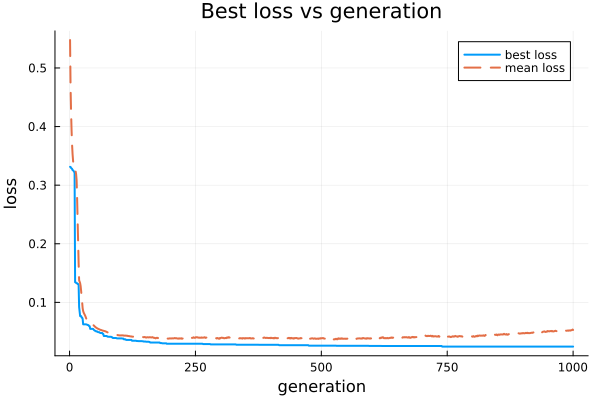

In [10]:
plot(state.history.best_loss, label="best loss", xlabel="generation", ylabel="loss", title="Best loss vs generation", lw=2, legend=:topright)
plot!(state.history.mean_loss, label="mean loss", lw=2, line=:dash)

In [11]:
best = argmin(state.fitness)
println("Best loss: ", state.fitness[best])

Best loss: 0.02458553337611394


Optimal index: 105
Adaptation error: 0.21009903664905016
sensitivity: 0.07714797073541346 and  loss : 0.06714797073541347


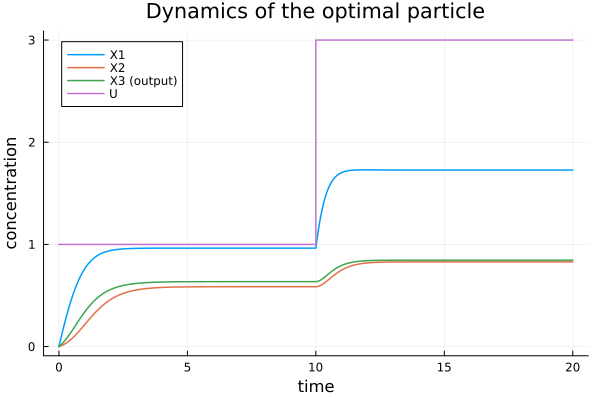

In [30]:
perturb = 2
opt_index = sortperm(state.fitness)[1]


opt_pars_v = state.pool[opt_index]
opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)

sol = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, 1., [ perturb ], t0, t1)[1]
println("Optimal index: ", opt_index)
println("Adaptation error: ", abs(sol(t0)[3] - sol(t1)[3]))
println("sensitivity: ", abs(sol(t0)[3] - sol(t0+0.5)[3]), " and  loss : ", abs(abs(sol(t0)[3] - sol(t0+0.5)[3]) - 0.01))
plot(sol.t, vec2mat(sol.u)[:,1:4], label=["X1" "X2" "X3 (output)" "U"], lw=1.5, title="Dynamics of the optimal particle", xlabel="time", ylabel="concentration")

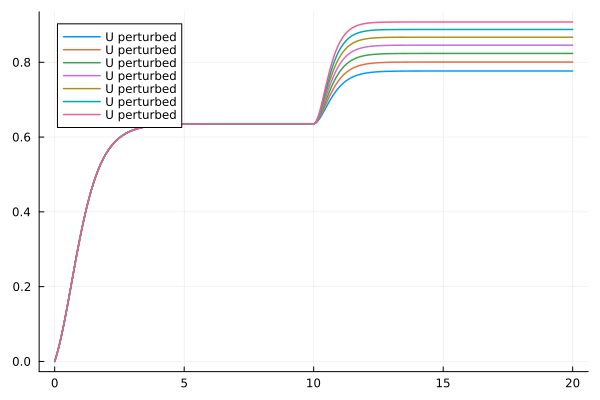

In [31]:
inputs = [0.25, 0.50, 0.75, 1., 1.25, 1.50, 1.75].+1.

solutions = run_with_fixed_perturbations(crn, opt_pars_v, opt_pars_l, 1., inputs, t0, t1)
plot()
sss = [] 
for sol in solutions
    plot!(sol.t, vec2mat(sol.u)[:,3], lw=1.5, label="U perturbed")
    push!(sss, sol(t1)[3])
end
plot!()

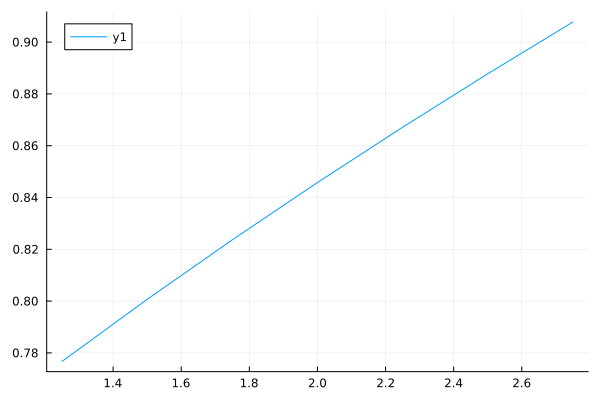

In [32]:
plot(inputs, sss)

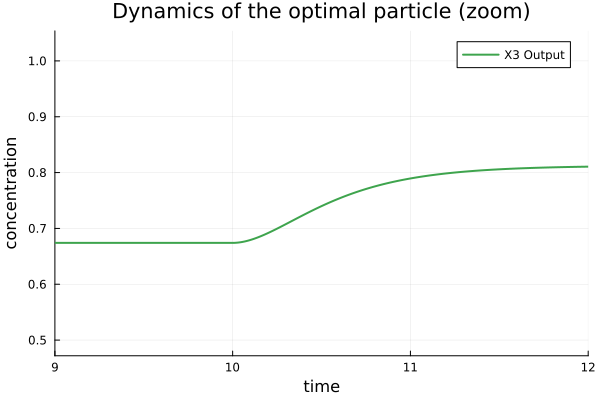

In [15]:
# zoom on reaction 3
plot(sol.t, vec2mat(sol.u)[:,3], label="X3 Output", xlabel="time", ylabel="concentration", title="Dynamics of the optimal particle (zoom)", lw=2, color=3)
xlims!(t0-1., t0+2)
ylims!(sol(t0-1)[3]-sol(t0-1)[3]*0.3, sol(t0+2)[3]+sol(t0+2)[3]*0.3)

In [38]:
gd_options_for_output = (
    alpha = gd_options.alpha/10,
    n_iter = gd_options.n_iter*100,
    use_pruning_heuristic = gd_options.use_pruning_heuristic,
    clip_value = gd_options.clip_value,
    use_gradient_normalization = gd_options.use_gradient_normalization,
    use_adagrad = gd_options.use_adagrad, # overrides use_adam!
    use_adam = gd_options.use_adam,
    use_random_perturbation = gd_options.use_random_perturbation,
    verbose = true,
    # placed here for convenience, should be in gd_loss_options
    symbolic_derivatives_of_loss = gd_options.symbolic_derivatives_of_loss
)
out = symbolic_gradient_descent(state.pool[best], crn_info, gd_options_for_output, gd_perturbation_options, gd_loss_options)
println("done")

done


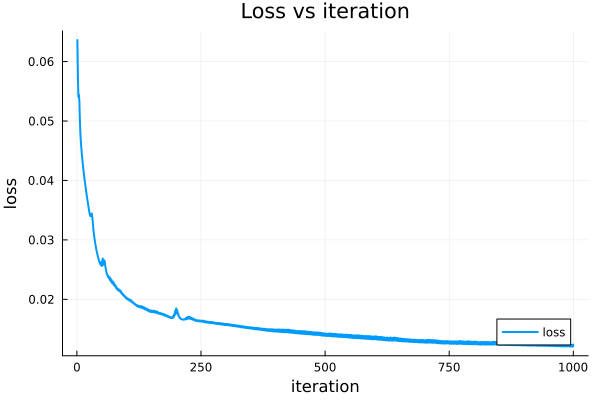

In [39]:
plot(1:length(out.loss_tape), out.loss_tape, label="loss", xlabel="iteration", ylabel="loss", title="Loss vs iteration", lw=2, legend=:bottomright)

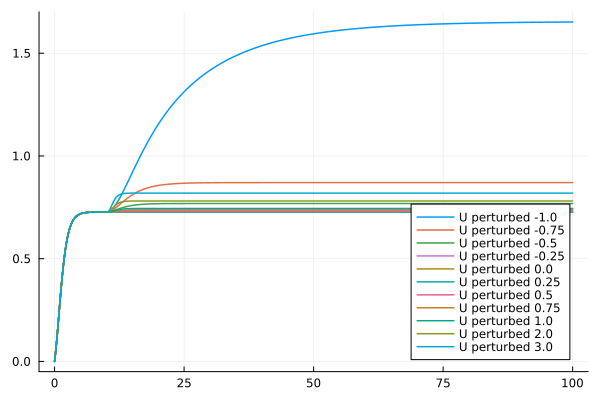

In [72]:
inputs = [0., 0.25, 0.50, 0.75, 1., 1.25, 1.50, 1.75, 2, 3., 4.] .-1

pars_out_l = assemble_opt_parameters_and_varables(out.parameter_tape[end], N)
solutions = run_with_fixed_perturbations(crn, out.parameter_tape[end], pars_out_l, 1., inputs, t0, 100)
plot()
sss = [] 
for i in 1:length(solutions)
    plot!(solutions[i].t, vec2mat(solutions[i].u)[:,3], lw=1.5, label="U perturbed $(inputs[i])")
    push!(sss, solutions[i](t1)[3])
end
plot!()

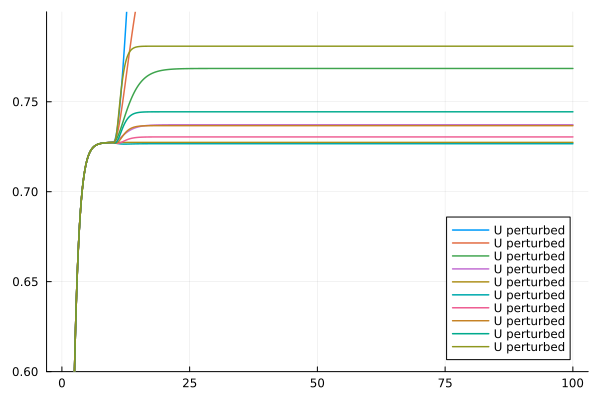

In [66]:
ylims!(0.6, 0.8)
plot!()

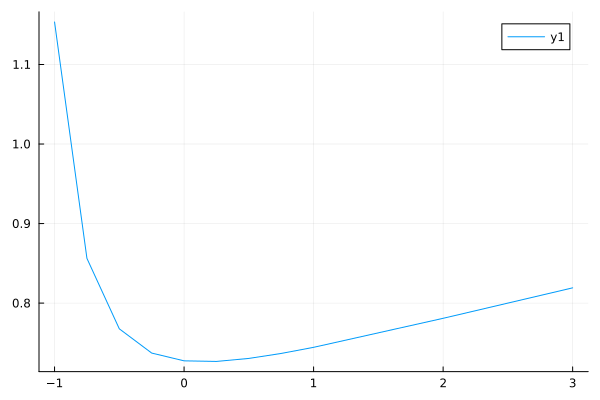

In [73]:
plot(inputs, sss)

In [18]:
using Symbolics
using LinearAlgebra
function joint_jacobian(i, j, jac, initial_conditions)
    A_ij = substitute(jac[i, j], unsym_dict(initial_conditions))
    return A_ij
end

opt_index = 1
# opt_index = argmin(predictions)
# opt_index = length(loss_tape)

opt_pars_v = state.pool[opt_index]
opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)

jac = Symbolics.substitute(calculate_jacobian(ode_crn), unsym_dict(opt_pars_l.p))

perturb = 2.5
steady_state_after_perturbation = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, 1., [ perturb ], t0, t1)[1](t1)[1:3]
steady_state_after_perturbation = [
    :x_1 => steady_state_after_perturbation[1],
    :x_2 => steady_state_after_perturbation[2],
    :x_3 => steady_state_after_perturbation[3]
]

A_21 = joint_jacobian(2, 1, jac, steady_state_after_perturbation)
A_32 = joint_jacobian(3, 2, jac, steady_state_after_perturbation)
A_22 = joint_jacobian(2, 2, jac, steady_state_after_perturbation)
A_31 = joint_jacobian(3, 1, jac, steady_state_after_perturbation)

println("A_21 = ", A_21)
println("A_32 = ", A_32)
println("A_22 = ", A_22)
println("A_31 = ", A_31)
println("A_22*A_31 = ", A_22*A_31)
println("A_21*A_32 = ", A_21*A_32)
println("A_22*A_31 - A_21*A_32 = ", A_22*A_31 - A_21*A_32)

A_21 = 0.051775932038772066


A_32 = 0.670750583702489
A_22 = -3.0926164355716517
A_31 = 0.9235539832371973
A_22*A_31 = -2.856198227697022
A_21*A_32 = 0.03472873663674676
A_22*A_31 - A_21*A_32 = -2.8909269643337687


In [19]:
# homeostatic_coefs_A21_A32 = []
# homeostatic_coefs_A22_A31 = []
# homeostatic_coefs = []

# for par_set in state.pool
#     opt_pars_v = par_set
#     opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)

#     jac = Symbolics.substitute(calculate_jacobian(ode_crn), unsym_dict(opt_pars_l.p))

#     perturb = 2.5
#     steady_state_after_perturbation = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, 1., [ perturb ], t0, t1)[1](t1)[1:3]
#     steady_state_after_perturbation = [
#         :x_1 => steady_state_after_perturbation[1],
#         :x_2 => steady_state_after_perturbation[2],
#         :x_3 => steady_state_after_perturbation[3]
#     ]

#     A_21 = joint_jacobian(2, 1, jac, steady_state_after_perturbation)
#     A_32 = joint_jacobian(3, 2, jac, steady_state_after_perturbation)
#     A_22 = joint_jacobian(2, 2, jac, steady_state_after_perturbation)
#     A_31 = joint_jacobian(3, 1, jac, steady_state_after_perturbation)

#     push!(homeostatic_coefs_A21_A32, A_21*A_32)
#     push!(homeostatic_coefs_A22_A31, A_22*A_31)
#     push!(homeostatic_coefs, A_22*A_31 - A_21*A_32)
# end

In [20]:
# histogram([x.val for x in homeostatic_coefs], label=false, xlabel="Homeostatic coefficient", ylabel="frequency", title="Homeostatic coefficient distribution", lw=0.5, legend=:bottomright)

In [21]:
# histogram([x.val for x in homeostatic_coefs_A21_A32], label=false, xlabel="A_21*A_32", ylabel="frequency", title="Homeostatic coefficient distribution", lw=1, legend=:bottomright)

In [22]:
# histogram([x.val for x in homeostatic_coefs_A22_A31], label=false, xlabel="A_21*A_32", ylabel="frequency", title="Homeostatic coefficient distribution", lw=0.5, legend=:bottomright)

In [23]:
# histogram([ x.val for x in homeostatic_coefs_A21_A32 + homeostatic_coefs_A22_A31], xlabel="A21_A32 + A22_A31", ylabel="frequency", title="Homeostatic coefficient distribution", lw=1, legend=false)

In [24]:
# plot([x.val for x in homeostatic_coefs_A22_A31], [x.val for x in homeostatic_coefs_A21_A32], seriestype = :scatter, xlabel="A_22*A_31", ylabel="A_21*A_32", title="Components of the homeostatic coefficient", lw=2, legend=:bottomright, alpha=0.5)
# xlims!(-85,0)
# ylims!(-60,0)

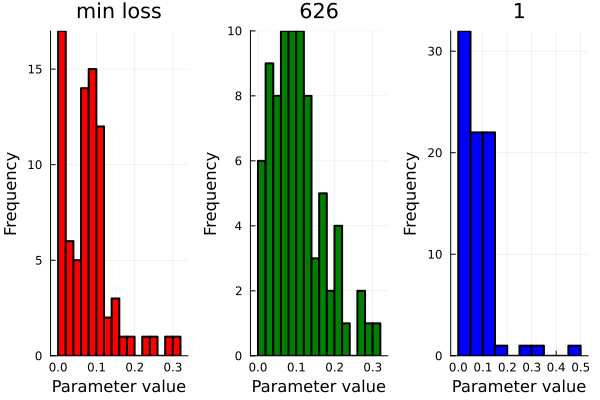

In [25]:
opt_index_options = [best, rand(1:length(state.pool)), 1]
opt_index_options_labels = ["min loss", "$(opt_index_options[2])", "1"]
opt_index_options_colors = [:red, :green, :blue]

hists = []
for i in 1:length(opt_index_options)
    opt_index = opt_index_options[i]
    opt_pars_v = state.pool[opt_index]
    opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, 3)
    h = histogram(opt_pars_v, label=opt_index_options_labels[i], xlabel="Parameter value", ylabel="Frequency", title=opt_index_options_labels[i], lw=2, legend=false, color=opt_index_options_colors[i], bins=20)
    push!(hists, h)
end
plot(hists..., layout=(1,3))

In [128]:
for i in reverse(sortperm((out.parameter_tape[end])))
    if out.parameter_tape[end][i] < 0.1
        continue
    end
    println(reactions(crn)[i], " = ", out.parameter_tape[end][i])
end

k_31, x_1 + x_2 --> ∅ = 0.3249043728532883
k_3, ∅ --> x_1 + x_2 = 0.20276869164726444
k_40, x_1 + x_2 --> x_3 = 0.20002339019555018
k_30, 2*x_1 --> ∅ = 0.12171569180616508


(p = Dict(:k_19 => 0.0, :k_66 => 0.0, :k_74 => 0.0, :k_48 => 0.0, :k_34 => 0.0, :k_45 => 0.0, :k_58 => 0.0, :k_11 => 0.0, :k_56 => 0.0, :k_6 => 0.0…), u0 = [:x_1 => 0.0, :x_2 => 0.0, :x_3 => 0.0])

In [104]:
ode_crn

Model crn with 3 equations
States (4):
  x_1(t)
  x_2(t)
  x_3(t)
  U(t)
Parameters (80):
  k_1
  k_2
  k_3
  k_4
⋮

In [188]:
function run_with_fixed_perturbations(crn_ode, pars_v, pars_l, input, perturbation_list, t0, t1)
    condition = [t0]
    solutions = Array{Any}(undef, length(perturbation_list))
    params = pars_l.p
    delete!(params, :U)
    crn_ode = Symbolics.substitute(crn_ode, unsym_dict(params))
    prob = ODEProblem(crn_ode, [pars_l.u0;[:U => 1.]], (0., t1))

    Threads.@threads for i in 1:length(perturbation_list)
        function affect!(integrator)
            integrator[:U] = max(0., input + perturbation_list[i])
        end
        ps_cb = PresetTimeCallback(condition, affect!)
        sol = solve(prob, Tsit5(), reltol=1e-12, abstol=1e-12, callback=ps_cb)
        solutions[i] = sol
    end
    return solutions
end

run_with_fixed_perturbations (generic function with 1 method)

In [189]:
inputs = [0.1, 0.25, 0.50, 0.75, 1., 1.25, 1.50, 1.75, 2, 3., 4.] .-1

lim = 0.1
pars_out_l = assemble_opt_parameters_and_varables(out.parameter_tape[end].*(out.parameter_tape[end] .> lim), N)
solutions = run_with_fixed_perturbations(ode_crn, out.parameter_tape[end].*(out.parameter_tape[end] .> lim), pars_out_l, 1., inputs, t0, 100)
plot()
sss = [] 
for i in 1:length(solutions)
    plot!(solutions[i].t, vec2mat(solutions[i].u)[:,3], lw=1.5, label="U perturbed $(inputs[i])")
    push!(sss, solutions[i](t1)[3])
end
plot!()

ArgumentError: ArgumentError: Any[x_1(t), x_2(t), x_3(t), U(t)] are missing from the variable map.

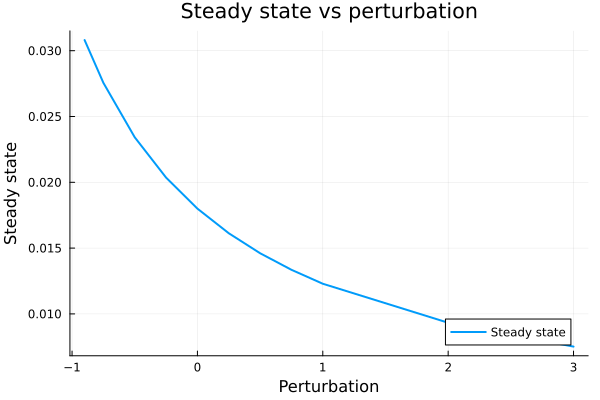

In [129]:
plot(inputs, sss, lw=2, label="Steady state", xlabel="Perturbation", ylabel="Steady state", title="Steady state vs perturbation", legend=:bottomright)

In [147]:
pars_out_l.p[:U] = 1.
new_ode = substitute(ode_crn, unsym_dict(pars_out_l.p))

Model crn with 3 equations
States (3):
  x_1(t)
  x_2(t)
  x_3(t)
Parameters (0):

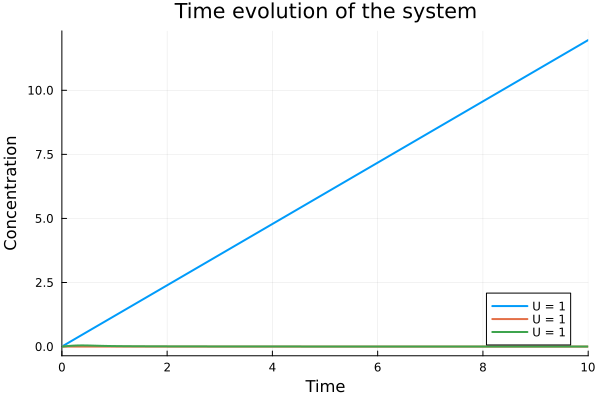

In [148]:
# solve the new_ode
function fun(x, p, t)
    dx = 1.2028 - 0.3249*x[1]*x[3] - 0.12172*x[1]*x[2] 
    dy = -0.1217*x[1]*x[2]
    dz = 0.20277 - 9.5249*x[3]*x[1]
    [dx, dy, dz]
end

prob = ODEProblem(fun, [0.;0.;0.], (0, 10.))
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
plot(sol, lw=2, label="U = 1", xlabel="Time", ylabel="Concentration", title="Time evolution of the system", legend=:bottomright)

Model crn with 3 equations
States (3):
  x_1(t)
  x_2(t)
  x_3(t)
Parameters (0):

In [79]:
out.parameter_tape[end]

80-element Vector{Float64}:
 0.0
 0.00024750627765396307
 0.0
 0.20276869164726444
 0.0
 0.0
 0.00021121903438953778
 0.0006461037668952116
 0.0001336373944559065
 6.911049932716415e-5
 ⋮
 0.00017201774352613425
 0.0004247639165052079
 0.0
 0.0007267400349581602
 0.00019603422294818244
 0.0
 0.0002583379172357247
 0.0
 0.0

In [27]:
# using Pkg; Pkg.add("JLD2")

In [28]:
using JLD2

save_object("Ultra-Sensitivity2.jld2", Dict(
    "state" => state,
    # all parameters 
    "ga_options" => Dict(
        genetic_pool_size => genetic_pool_size,
        elite => elite,
        worst => worst,
        death_rate => death_rate,
        mutation_rate => mutation_rate,
        gradient_mutation_rate => gradient_mutation_rate,
        duplication_rate => duplication_rate,
        crossover_rate => crossover_rate,
        max_generations => max_generations,
        p_cross => p_cross
    ),
    "crn_info" => crn_info,
    "gd_loss_options" => gd_loss_options,
    "gd_options" => gd_options,
    "gd_perturbation_options" => gd_perturbation_options
))    


In [29]:
# test_load = load_object("Ultra-Sensitivity.jld2") 